In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import aesara
import aesara.tensor as T
import matplotlib.pyplot as plt
import arviz as az
import math
import seaborn as sns
import pickle
from gapminder import gapminder # data set

RANDOM_SEED = 227
rng = np.random.default_rng(RANDOM_SEED)
aesara.config.compute_test_value='off'
aesara.config.floatX = 'float32'
%config InlineBackend.figure_format = 'retina'

#https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

In [2]:
def phi_corr(p_a,p_b,p_a_and_b):
    numerator = p_a_and_b-p_a*p_b
    denominator = np.sqrt(p_a*(1-p_a)*p_b*(1-p_b))
    return numerator/denominator

def phi_corr2(p_a,p_b,p_a_given_b):
    numerator = (p_a_given_b-p_a)*p_b
    denominator = np.sqrt(p_a*(1-p_a)*p_b*(1-p_b))
    return numerator/denominator

In [19]:
data = pd.read_excel('toy.xlsx',sheet_name='certain')
data = data.drop(columns=['P(A)','P(B)','P(C|A)','P(C|B)','P(D|C)'])

# For P_A, P_B... 

A, B, C, D = data['A'], data['B'], data['C'], data['D']
length = 12 # hours

num_step = math.floor(len(A)/length)
A_dist, B_dist, C_dist, D_dist = [np.zeros((1,num_step)).ravel() for i in [1,1,1,1]]

for i in np.arange(num_step):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_dist[i] = np.sum(A[(i-1)*length:i*length])
    B_dist[i] = np.sum(B[(i-1)*length:i*length])
    C_dist[i] = np.sum(C[(i-1)*length:i*length])
    D_dist[i] = np.sum(D[(i-1)*length:i*length])

# For P_A_given_B (conditional probs)... 
B_given_A0 = data[data['A']==0]['B']
C_given_A0 = data[data['A']==0]['C']
D_given_A0 = data[data['A']==0]['D']
A_given_B0 = data[data['B']==0]['A']
C_given_B0 = data[data['B']==0]['C']
D_given_B0 = data[data['B']==0]['D']
A_given_C0 = data[data['C']==0]['A']
B_given_C0 = data[data['C']==0]['B']
D_given_C0 = data[data['C']==0]['D']
A_given_D0 = data[data['D']==0]['A']
B_given_D0 = data[data['D']==0]['B']
C_given_D0 = data[data['D']==0]['C']

num_step_given_A0 = math.floor(len(B_given_A0)/length)
num_step_given_B0 = math.floor(len(A_given_B0)/length)
num_step_given_C0 = math.floor(len(A_given_C0)/length)
num_step_given_D0 = math.floor(len(A_given_D0)/length)

B_given_A0_dist, C_given_A0_dist, D_given_A0_dist = [np.zeros((1,num_step_given_A0)).ravel() for i in [1,1,1]]
A_given_B0_dist, C_given_B0_dist, D_given_B0_dist = [np.zeros((1,num_step_given_B0)).ravel() for i in [1,1,1]]
A_given_C0_dist, B_given_C0_dist, D_given_C0_dist = [np.zeros((1,num_step_given_C0)).ravel() for i in [1,1,1]]
A_given_D0_dist, B_given_D0_dist, C_given_D0_dist = [np.zeros((1,num_step_given_D0)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_A0):
    B_given_A0_dist[i] = np.sum(B_given_A0[(i-1)*length:i*length])
    C_given_A0_dist[i] = np.sum(C_given_A0[(i-1)*length:i*length])
    D_given_A0_dist[i] = np.sum(D_given_A0[(i-1)*length:i*length])

for i in np.arange(num_step_given_B0):
    A_given_B0_dist[i] = np.sum(A_given_B0[(i-1)*length:i*length])
    C_given_B0_dist[i] = np.sum(C_given_B0[(i-1)*length:i*length])
    D_given_B0_dist[i] = np.sum(D_given_B0[(i-1)*length:i*length])

for i in np.arange(num_step_given_C0):
    A_given_C0_dist[i] = np.sum(A_given_C0[(i-1)*length:i*length])
    B_given_C0_dist[i] = np.sum(B_given_C0[(i-1)*length:i*length])
    D_given_C0_dist[i] = np.sum(D_given_C0[(i-1)*length:i*length])

for i in np.arange(num_step_given_D0):
    A_given_D0_dist[i] = np.sum(A_given_D0[(i-1)*length:i*length])
    B_given_D0_dist[i] = np.sum(B_given_D0[(i-1)*length:i*length])
    C_given_D0_dist[i] = np.sum(C_given_D0[(i-1)*length:i*length])

B_given_A1 = data[data['A']==1]['B']
C_given_A1 = data[data['A']==1]['C']
D_given_A1 = data[data['A']==1]['D']
A_given_B1 = data[data['B']==1]['A']
C_given_B1 = data[data['B']==1]['C']
D_given_B1 = data[data['B']==1]['D']
A_given_C1 = data[data['C']==1]['A']
B_given_C1 = data[data['C']==1]['B']
D_given_C1 = data[data['C']==1]['D']
A_given_D1 = data[data['D']==1]['A']
B_given_D1 = data[data['D']==1]['B']
C_given_D1 = data[data['D']==1]['C']

num_step_given_A1 = math.floor(len(B_given_A1)/length)
num_step_given_B1 = math.floor(len(A_given_B1)/length)
num_step_given_C1 = math.floor(len(A_given_C1)/length)
num_step_given_D1 = math.floor(len(A_given_D1)/length)

B_given_A1_dist, C_given_A1_dist, D_given_A1_dist = [np.zeros((1,num_step_given_A1)).ravel() for i in [1,1,1]]
A_given_B1_dist, C_given_B1_dist, D_given_B1_dist = [np.zeros((1,num_step_given_B1)).ravel() for i in [1,1,1]]
A_given_C1_dist, B_given_C1_dist, D_given_C1_dist = [np.zeros((1,num_step_given_C1)).ravel() for i in [1,1,1]]
A_given_D1_dist, B_given_D1_dist, C_given_D1_dist = [np.zeros((1,num_step_given_D1)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_A1):
    B_given_A1_dist[i] = np.sum(B_given_A1[(i-1)*length:i*length])
    C_given_A1_dist[i] = np.sum(C_given_A1[(i-1)*length:i*length])
    D_given_A1_dist[i] = np.sum(D_given_A1[(i-1)*length:i*length])

for i in np.arange(num_step_given_B1):
    A_given_B1_dist[i] = np.sum(A_given_B1[(i-1)*length:i*length])
    C_given_B1_dist[i] = np.sum(C_given_B1[(i-1)*length:i*length])
    D_given_B1_dist[i] = np.sum(D_given_B1[(i-1)*length:i*length])

for i in np.arange(num_step_given_C1):
    A_given_C1_dist[i] = np.sum(A_given_C1[(i-1)*length:i*length])
    B_given_C1_dist[i] = np.sum(B_given_C1[(i-1)*length:i*length])
    D_given_C1_dist[i] = np.sum(D_given_C1[(i-1)*length:i*length])

for i in np.arange(num_step_given_D1):
    A_given_D1_dist[i] = np.sum(A_given_D1[(i-1)*length:i*length])
    B_given_D1_dist[i] = np.sum(B_given_D1[(i-1)*length:i*length])
    C_given_D1_dist[i] = np.sum(C_given_D1[(i-1)*length:i*length])

# Joint probability 
A_and_B_dist, A_and_C_dist, A_and_D_dist, B_and_C_dist, B_and_D_dist, C_and_D_dist = [np.zeros((1,num_step)).ravel() for i in [1,1,1,1,1,1]]

for i in np.arange(num_step):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_and_B_dist[i] = np.sum(A*B[(i-1)*length:i*length])
    A_and_C_dist[i] = np.sum(A*C[(i-1)*length:i*length])
    A_and_D_dist[i] = np.sum(A*D[(i-1)*length:i*length])
    B_and_C_dist[i] = np.sum(B*C[(i-1)*length:i*length])
    B_and_D_dist[i] = np.sum(B*D[(i-1)*length:i*length])
    C_and_D_dist[i] = np.sum(C*D[(i-1)*length:i*length])  

# Conditional joint probs over C
given_C0_data = data[data['C']==0]
A_given_C0 = given_C0_data['A']
B_given_C0 = given_C0_data['B']
D_given_C0 = given_C0_data['D']
num_step_given_C0 = math.floor(len(given_C0_data)/length)

A_and_B_given_C0_dist, A_and_D_given_C0_dist, B_and_D_given_C0_dist = [np.zeros((1,num_step_given_C0)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_C0):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_and_B_given_C0_dist[i] = np.sum(A_given_C0*B_given_C0[(i-1)*length:i*length])
    A_and_D_given_C0_dist[i] = np.sum(A_given_C0*D_given_C0[(i-1)*length:i*length])
    B_and_D_given_C0_dist[i] = np.sum(A_given_C0*D_given_C0[(i-1)*length:i*length])

given_C1_data = data[data['C']==1]
A_given_C1 = given_C1_data['A']
B_given_C1 = given_C1_data['B']
D_given_C1 = given_C1_data['D']
num_step_given_C1 = math.floor(len(given_C1_data)/length)

A_and_B_given_C1_dist, A_and_D_given_C1_dist, B_and_D_given_C1_dist = [np.zeros((1,num_step_given_C1)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_C1):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_and_B_given_C1_dist[i] = np.sum(A_given_C1*B_given_C1[(i-1)*length:i*length])
    A_and_D_given_C1_dist[i] = np.sum(A_given_C1*D_given_C1[(i-1)*length:i*length])
    B_and_D_given_C1_dist[i] = np.sum(A_given_C1*D_given_C1[(i-1)*length:i*length])

# Conditional joint probs over D 
given_D0_data = data[data['D']==0]
A_given_D0 = given_D0_data['A']
B_given_D0 = given_D0_data['B']
C_given_D0 = given_D0_data['C']
num_step_given_D0 = math.floor(len(given_D0_data)/length)

A_and_B_given_D0_dist, A_and_C_given_D0_dist, B_and_C_given_D0_dist = [np.zeros((1,num_step_given_D0)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_D0):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_and_B_given_D0_dist[i] = np.sum(A_given_D0*B_given_D0[(i-1)*length:i*length])
    A_and_C_given_D0_dist[i] = np.sum(A_given_D0*C_given_D0[(i-1)*length:i*length])
    B_and_C_given_D0_dist[i] = np.sum(B_given_D0*C_given_D0[(i-1)*length:i*length])

# Conditional joint probs over D 
given_D1_data = data[data['D']==1]
A_given_D1 = given_D1_data['A']
B_given_D1 = given_D1_data['B']
C_given_D1 = given_D1_data['C']
num_step_given_D1 = math.floor(len(given_D1_data)/length)

A_and_B_given_D1_dist, A_and_C_given_D1_dist, B_and_C_given_D1_dist = [np.zeros((1,num_step_given_D1)).ravel() for i in [1,1,1]]

for i in np.arange(num_step_given_D1):
    # print(np.sum(A[(i-1)*length:i*length]))
    A_and_B_given_D1_dist[i] = np.sum(A_given_D1*B_given_D1[(i-1)*length:i*length])
    A_and_C_given_D1_dist[i] = np.sum(A_given_D1*C_given_D1[(i-1)*length:i*length])
    B_and_C_given_D1_dist[i] = np.sum(A_given_D1*C_given_D1[(i-1)*length:i*length])

In [31]:
with pm.Model() as model:
    prior_alpha = 2
    prior_beta = 1

    # (1) Marginal probs
    alpha0_A = pm.Gamma('alpha0_A', alpha = prior_alpha, beta=prior_beta)
    alpha0_B = pm.Gamma('alpha0_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_C = pm.Gamma('alpha0_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_D = pm.Gamma('alpha0_D', alpha = prior_alpha, beta=prior_beta)

    beta0_A = pm.Gamma('beta0_A', alpha = prior_alpha, beta =prior_beta)
    beta0_B = pm.Gamma('beta0_B', alpha = prior_alpha, beta =prior_beta)
    beta0_C = pm.Gamma('beta0_C', alpha = prior_alpha, beta =prior_beta)
    beta0_D = pm.Gamma('beta0_D', alpha = prior_alpha, beta =prior_beta)

    p_A = pm.Beta('p_A', alpha = alpha0_A, beta = beta0_A)
    p_B = pm.Beta('p_B', alpha = alpha0_B, beta = beta0_B)
    p_C = pm.Beta('p_C', alpha = alpha0_C, beta = beta0_C)
    p_D = pm.Beta('p_D', alpha = alpha0_D, beta = beta0_D)
    
    # They are for to get P(A), P(B), P(C), and P(D)
    bino_A = pm.Binomial('bino_A', n = length, p = p_A, observed = A_dist)
    bino_B = pm.Binomial('bino_B', n = length, p = p_B, observed = B_dist)
    bino_C = pm.Binomial('bino_C', n = length, p = p_C, observed = C_dist)
    bino_D = pm.Binomial('bino_D', n = length, p = p_D, observed = D_dist)
    
    # (2) Conditional probs when give 0

    alpha0_A_given_B0 = pm.Gamma('alpha0_A_given_B0', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_given_C0 = pm.Gamma('alpha0_A_given_C0', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_given_D0 = pm.Gamma('alpha0_A_given_D0', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_given_A0 = pm.Gamma('alpha0_B_given_A0', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_given_C0 = pm.Gamma('alpha0_B_given_C0', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_given_D0 = pm.Gamma('alpha0_B_given_D0', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_given_A0 = pm.Gamma('alpha0_C_given_A0', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_given_B0 = pm.Gamma('alpha0_C_given_B0', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_given_D0 = pm.Gamma('alpha0_C_given_D0', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_given_A0 = pm.Gamma('alpha0_D_given_A0', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_given_B0 = pm.Gamma('alpha0_D_given_B0', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_given_C0 = pm.Gamma('alpha0_D_given_C0', alpha = prior_alpha, beta=prior_beta)

    beta0_A_given_B0 = pm.Gamma('beta0_A_given_B0', alpha = prior_alpha, beta=prior_beta)
    beta0_A_given_C0 = pm.Gamma('beta0_A_given_C0', alpha = prior_alpha, beta=prior_beta)
    beta0_A_given_D0 = pm.Gamma('beta0_A_given_D0', alpha = prior_alpha, beta=prior_beta)
    beta0_B_given_A0 = pm.Gamma('beta0_B_given_A0', alpha = prior_alpha, beta=prior_beta)
    beta0_B_given_C0 = pm.Gamma('beta0_B_given_C0', alpha = prior_alpha, beta=prior_beta)
    beta0_B_given_D0 = pm.Gamma('beta0_B_given_D0', alpha = prior_alpha, beta=prior_beta)
    beta0_C_given_A0 = pm.Gamma('beta0_C_given_A0', alpha = prior_alpha, beta=prior_beta)
    beta0_C_given_B0 = pm.Gamma('beta0_C_given_B0', alpha = prior_alpha, beta=prior_beta)
    beta0_C_given_D0 = pm.Gamma('beta0_C_given_D0', alpha = prior_alpha, beta=prior_beta)
    beta0_D_given_A0 = pm.Gamma('beta0_D_given_A0', alpha = prior_alpha, beta=prior_beta)
    beta0_D_given_B0 = pm.Gamma('beta0_D_given_B0', alpha = prior_alpha, beta=prior_beta)
    beta0_D_given_C0 = pm.Gamma('beta0_D_given_C0', alpha = prior_alpha, beta=prior_beta)

    p_A_given_B0 = pm.Beta('p_A_given_B0', alpha = alpha0_A_given_B0, beta= beta0_A_given_B0)
    p_A_given_C0 = pm.Beta('p_A_given_C0', alpha = alpha0_A_given_C0, beta= beta0_A_given_C0)
    p_A_given_D0 = pm.Beta('p_A_given_D0', alpha = alpha0_A_given_D0, beta= beta0_A_given_D0)
    p_B_given_A0 = pm.Beta('p_B_given_A0', alpha = alpha0_B_given_A0, beta= beta0_B_given_A0)
    p_B_given_C0 = pm.Beta('p_B_given_C0', alpha = alpha0_B_given_C0, beta= beta0_B_given_C0)
    p_B_given_D0 = pm.Beta('p_B_given_D0', alpha = alpha0_B_given_D0, beta= beta0_B_given_D0)
    p_C_given_A0 = pm.Beta('p_C_given_A0', alpha = alpha0_C_given_A0, beta= beta0_C_given_A0)
    p_C_given_B0 = pm.Beta('p_C_given_B0', alpha = alpha0_C_given_B0, beta= beta0_C_given_B0)
    p_C_given_D0 = pm.Beta('p_C_given_D0', alpha = alpha0_C_given_D0, beta= beta0_C_given_D0)
    p_D_given_A0 = pm.Beta('p_D_given_A0', alpha = alpha0_D_given_A0, beta= beta0_D_given_A0)
    p_D_given_B0 = pm.Beta('p_D_given_B0', alpha = alpha0_D_given_B0, beta= beta0_D_given_B0)
    p_D_given_C0 = pm.Beta('p_D_given_C0', alpha = alpha0_D_given_C0, beta= beta0_D_given_C0)

    # They are for to get conditional probabilities
    bino_A_given_B0 = pm.Binomial('bino_A_given_B0', n = length, p= p_A_given_B0, observed = A_given_B0_dist)
    bino_A_given_C0 = pm.Binomial('bino_A_given_C0', n = length, p= p_A_given_C0, observed = A_given_C0_dist)
    bino_A_given_D0 = pm.Binomial('bino_A_given_D0', n = length, p= p_A_given_D0, observed = A_given_D0_dist)
    bino_B_given_A0 = pm.Binomial('bino_B_given_A0', n = length, p= p_B_given_A0, observed = B_given_A0_dist)
    bino_B_given_C0 = pm.Binomial('bino_B_given_C0', n = length, p= p_B_given_C0, observed = B_given_C0_dist)
    bino_B_given_D0 = pm.Binomial('bino_B_given_D0', n = length, p= p_B_given_D0, observed = B_given_D0_dist)
    bino_C_given_A0 = pm.Binomial('bino_C_given_A0', n = length, p= p_C_given_A0, observed = C_given_A0_dist)
    bino_C_given_B0 = pm.Binomial('bino_C_given_B0', n = length, p= p_C_given_B0, observed = C_given_B0_dist)
    bino_C_given_D0 = pm.Binomial('bino_C_given_D0', n = length, p= p_C_given_D0, observed = C_given_D0_dist)
    bino_D_given_A0 = pm.Binomial('bino_D_given_A0', n = length, p= p_D_given_A0, observed = D_given_A0_dist)
    bino_D_given_B0 = pm.Binomial('bino_D_given_B0', n = length, p= p_D_given_B0, observed = D_given_B0_dist)
    bino_D_given_C0 = pm.Binomial('bino_D_given_C0', n = length, p= p_D_given_C0, observed = D_given_C0_dist)

    # (2) Conditional probs when give 1

    alpha0_A_given_B1 = pm.Gamma('alpha0_A_given_B1', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_given_C1 = pm.Gamma('alpha0_A_given_C1', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_given_D1 = pm.Gamma('alpha0_A_given_D1', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_given_A1 = pm.Gamma('alpha0_B_given_A1', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_given_C1 = pm.Gamma('alpha0_B_given_C1', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_given_D1 = pm.Gamma('alpha0_B_given_D1', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_given_A1 = pm.Gamma('alpha0_C_given_A1', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_given_B1 = pm.Gamma('alpha0_C_given_B1', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_given_D1 = pm.Gamma('alpha0_C_given_D1', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_given_A1 = pm.Gamma('alpha0_D_given_A1', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_given_B1 = pm.Gamma('alpha0_D_given_B1', alpha = prior_alpha, beta=prior_beta)
    alpha0_D_given_C1 = pm.Gamma('alpha0_D_given_C1', alpha = prior_alpha, beta=prior_beta)

    beta0_A_given_B1 = pm.Gamma('beta0_A_given_B1', alpha = prior_alpha, beta=prior_beta)
    beta0_A_given_C1 = pm.Gamma('beta0_A_given_C1', alpha = prior_alpha, beta=prior_beta)
    beta0_A_given_D1 = pm.Gamma('beta0_A_given_D1', alpha = prior_alpha, beta=prior_beta)
    beta0_B_given_A1 = pm.Gamma('beta0_B_given_A1', alpha = prior_alpha, beta=prior_beta)
    beta0_B_given_C1 = pm.Gamma('beta0_B_given_C1', alpha = prior_alpha, beta=prior_beta)
    beta0_B_given_D1 = pm.Gamma('beta0_B_given_D1', alpha = prior_alpha, beta=prior_beta)
    beta0_C_given_A1 = pm.Gamma('beta0_C_given_A1', alpha = prior_alpha, beta=prior_beta)
    beta0_C_given_B1 = pm.Gamma('beta0_C_given_B1', alpha = prior_alpha, beta=prior_beta)
    beta0_C_given_D1 = pm.Gamma('beta0_C_given_D1', alpha = prior_alpha, beta=prior_beta)
    beta0_D_given_A1 = pm.Gamma('beta0_D_given_A1', alpha = prior_alpha, beta=prior_beta)
    beta0_D_given_B1 = pm.Gamma('beta0_D_given_B1', alpha = prior_alpha, beta=prior_beta)
    beta0_D_given_C1 = pm.Gamma('beta0_D_given_C1', alpha = prior_alpha, beta=prior_beta)

    p_A_given_B1 = pm.Beta('p_A_given_B1', alpha = alpha0_A_given_B1, beta= beta0_A_given_B1)
    p_A_given_C1 = pm.Beta('p_A_given_C1', alpha = alpha0_A_given_C1, beta= beta0_A_given_C1)
    p_A_given_D1 = pm.Beta('p_A_given_D1', alpha = alpha0_A_given_D1, beta= beta0_A_given_D1)
    p_B_given_A1 = pm.Beta('p_B_given_A1', alpha = alpha0_B_given_A1, beta= beta0_B_given_A1)
    p_B_given_C1 = pm.Beta('p_B_given_C1', alpha = alpha0_B_given_C1, beta= beta0_B_given_C1)
    p_B_given_D1 = pm.Beta('p_B_given_D1', alpha = alpha0_B_given_D1, beta= beta0_B_given_D1)
    p_C_given_A1 = pm.Beta('p_C_given_A1', alpha = alpha0_C_given_A1, beta= beta0_C_given_A1)
    p_C_given_B1 = pm.Beta('p_C_given_B1', alpha = alpha0_C_given_B1, beta= beta0_C_given_B1)
    p_C_given_D1 = pm.Beta('p_C_given_D1', alpha = alpha0_C_given_D1, beta= beta0_C_given_D1)
    p_D_given_A1 = pm.Beta('p_D_given_A1', alpha = alpha0_D_given_A1, beta= beta0_D_given_A1)
    p_D_given_B1 = pm.Beta('p_D_given_B1', alpha = alpha0_D_given_B1, beta= beta0_D_given_B1)
    p_D_given_C1 = pm.Beta('p_D_given_C1', alpha = alpha0_D_given_C1, beta= beta0_D_given_C1)

    # They are for to get conditional probabilities
    bino_A_given_B1 = pm.Binomial('bino_A_given_B1', n = length, p= p_A_given_B1, observed = A_given_B1_dist)
    bino_A_given_C1 = pm.Binomial('bino_A_given_C1', n = length, p= p_A_given_C1, observed = A_given_C1_dist)
    bino_A_given_D1 = pm.Binomial('bino_A_given_D1', n = length, p= p_A_given_D1, observed = A_given_D1_dist)
    bino_B_given_A1 = pm.Binomial('bino_B_given_A1', n = length, p= p_B_given_A1, observed = B_given_A1_dist)
    bino_B_given_C1 = pm.Binomial('bino_B_given_C1', n = length, p= p_B_given_C1, observed = B_given_C1_dist)
    bino_B_given_D1 = pm.Binomial('bino_B_given_D1', n = length, p= p_B_given_D1, observed = B_given_D1_dist)
    bino_C_given_A1 = pm.Binomial('bino_C_given_A1', n = length, p= p_C_given_A1, observed = C_given_A1_dist)
    bino_C_given_B1 = pm.Binomial('bino_C_given_B1', n = length, p= p_C_given_B1, observed = C_given_B1_dist)
    bino_C_given_D1 = pm.Binomial('bino_C_given_D1', n = length, p= p_C_given_D1, observed = C_given_D1_dist)
    bino_D_given_A1 = pm.Binomial('bino_D_given_A1', n = length, p= p_D_given_A1, observed = D_given_A1_dist)
    bino_D_given_B1 = pm.Binomial('bino_D_given_B1', n = length, p= p_D_given_B1, observed = D_given_B1_dist)
    bino_D_given_C1 = pm.Binomial('bino_D_given_C1', n = length, p= p_D_given_C1, observed = D_given_C1_dist)

    # Joint probs

    alpha0_A_and_B = pm.Gamma('alpha0_A_and_B', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_C = pm.Gamma('alpha0_A_and_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_D = pm.Gamma('alpha0_A_and_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_C = pm.Gamma('alpha0_B_and_C', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_D = pm.Gamma('alpha0_B_and_D', alpha = prior_alpha, beta=prior_beta)
    alpha0_C_and_D = pm.Gamma('alpha0_C_and_D', alpha = prior_alpha, beta=prior_beta)

    beta0_A_and_B = pm.Gamma('beta0_A_and_B', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_C = pm.Gamma('beta0_A_and_C', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_D = pm.Gamma('beta0_A_and_D', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_C = pm.Gamma('beta0_B_and_C', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_D = pm.Gamma('beta0_B_and_D', alpha = prior_alpha, beta=prior_beta)
    beta0_C_and_D = pm.Gamma('beta0_C_and_D', alpha = prior_alpha, beta=prior_beta)

    p_A_and_B = pm.Beta('p_A_and_B', alpha = alpha0_A_and_B, beta= beta0_A_and_B)
    p_A_and_C = pm.Beta('p_A_and_C', alpha = alpha0_A_and_C, beta= beta0_A_and_C)
    p_A_and_D = pm.Beta('p_A_and_D', alpha = alpha0_A_and_D, beta= beta0_A_and_D)
    p_B_and_C = pm.Beta('p_B_and_C', alpha = alpha0_B_and_C, beta= beta0_B_and_C)
    p_B_and_D = pm.Beta('p_B_and_D', alpha = alpha0_B_and_D, beta= beta0_B_and_D)
    p_C_and_D = pm.Beta('p_C_and_D', alpha = alpha0_C_and_D, beta= beta0_C_and_D)
    
    # They are for to get conditional probabilities
    bino_A_and_B = pm.Binomial('bino_A_and_B', n = length, p= p_A_and_B, observed = A_and_B_dist)
    bino_A_and_C = pm.Binomial('bino_A_and_C', n = length, p= p_A_and_C, observed = A_and_C_dist)
    bino_A_and_D = pm.Binomial('bino_A_and_D', n = length, p= p_A_and_D, observed = A_and_D_dist)
    bino_B_and_C = pm.Binomial('bino_B_and_C', n = length, p= p_B_and_C, observed = B_and_C_dist)
    bino_B_and_D = pm.Binomial('bino_B_and_D', n = length, p= p_B_and_D, observed = B_and_D_dist)
    bino_C_and_D = pm.Binomial('bino_C_and_D', n = length, p= p_C_and_D, observed = C_and_D_dist)

    # Conditonal joint probs when C =0 

    alpha0_A_and_B_given_C0 = pm.Gamma('alpha0_A_and_B_given_C0', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_D_given_C0 = pm.Gamma('alpha0_A_and_D_given_C0', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_D_given_C0 = pm.Gamma('alpha0_B_and_D_given_C0', alpha = prior_alpha, beta=prior_beta)

    beta0_A_and_B_given_C0 = pm.Gamma('beta0_A_and_B_given_C0', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_D_given_C0 = pm.Gamma('beta0_A_and_D_given_C0', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_D_given_C0 = pm.Gamma('beta0_B_and_D_given_C0', alpha = prior_alpha, beta=prior_beta)

    p_A_and_B_given_C0 = pm.Beta('p_A_and_B_given_C0', alpha = alpha0_A_and_B_given_C0, beta= beta0_A_and_B_given_C0)
    p_A_and_D_given_C0 = pm.Beta('p_A_and_D_given_C0', alpha = alpha0_A_and_D_given_C0, beta= beta0_A_and_D_given_C0)
    p_B_and_D_given_C0 = pm.Beta('p_B_and_D_given_C0', alpha = alpha0_B_and_D_given_C0, beta= beta0_B_and_D_given_C0)

    bino_A_and_B_given_C0 = pm.Binomial('bino_A_and_B_given_C0', n = length, p= p_A_and_B_given_C0, observed = A_and_B_given_C0_dist)
    bino_A_and_D_given_C0 = pm.Binomial('bino_A_and_D_given_C0', n = length, p= p_A_and_D_given_C0, observed = A_and_D_given_C0_dist)
    bino_B_and_D_given_C0 = pm.Binomial('bino_B_and_D_given_C0', n = length, p= p_B_and_D_given_C0, observed = B_and_D_given_C0_dist)

    # Conditonal joint probs when C = 1

    alpha0_A_and_B_given_C1 = pm.Gamma('alpha0_A_and_B_given_C1', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_D_given_C1 = pm.Gamma('alpha0_A_and_D_given_C1', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_D_given_C1 = pm.Gamma('alpha0_B_and_D_given_C1', alpha = prior_alpha, beta=prior_beta)

    beta0_A_and_B_given_C1 = pm.Gamma('beta0_A_and_B_given_C1', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_D_given_C1 = pm.Gamma('beta0_A_and_D_given_C1', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_D_given_C1 = pm.Gamma('beta0_B_and_D_given_C1', alpha = prior_alpha, beta=prior_beta)

    p_A_and_B_given_C1 = pm.Beta('p_A_and_B_given_C1', alpha = alpha0_A_and_B_given_C1, beta= beta0_A_and_B_given_C1)
    p_A_and_D_given_C1 = pm.Beta('p_A_and_D_given_C1', alpha = alpha0_A_and_D_given_C1, beta= beta0_A_and_D_given_C1)
    p_B_and_D_given_C1 = pm.Beta('p_B_and_D_given_C1', alpha = alpha0_B_and_D_given_C1, beta= beta0_B_and_D_given_C1)

    bino_A_and_B_given_C1 = pm.Binomial('bino_A_and_B_given_C1', n = length, p= p_A_and_B_given_C1, observed = A_and_B_given_C1_dist)
    bino_A_and_D_given_C1 = pm.Binomial('bino_A_and_D_given_C1', n = length, p= p_A_and_D_given_C1, observed = A_and_D_given_C1_dist)
    bino_B_and_D_given_C1 = pm.Binomial('bino_B_and_D_given_C1', n = length, p= p_B_and_D_given_C1, observed = B_and_D_given_C1_dist)

    # Conditonal joint probs when D = 0

    alpha0_A_and_B_given_D0 = pm.Gamma('alpha0_A_and_B_given_D0', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_C_given_D0 = pm.Gamma('alpha0_A_and_C_given_D0', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_C_given_D0 = pm.Gamma('alpha0_B_and_C_given_D0', alpha = prior_alpha, beta=prior_beta)

    beta0_A_and_C_given_D0 = pm.Gamma('beta0_A_and_C_given_D0', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_B_given_D0 = pm.Gamma('beta0_A_and_B_given_D0', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_C_given_D0 = pm.Gamma('beta0_B_and_C_given_D0', alpha = prior_alpha, beta=prior_beta)

    p_A_and_B_given_D0 = pm.Beta('p_A_and_B_given_D0', alpha = alpha0_A_and_B_given_D0, beta= beta0_A_and_B_given_D0)
    p_A_and_C_given_D0 = pm.Beta('p_A_and_C_given_D0', alpha = alpha0_A_and_C_given_D0, beta= beta0_A_and_C_given_D0)
    p_B_and_C_given_D0 = pm.Beta('p_B_and_C_given_D0', alpha = alpha0_B_and_C_given_D0, beta= beta0_B_and_C_given_D0)

    bino_A_and_B_given_D0 = pm.Binomial('bino_A_and_B_given_D0', n = length, p= p_A_and_B_given_D0, observed = A_and_B_given_D0_dist)
    bino_A_and_C_given_D0 = pm.Binomial('bino_A_and_C_given_D0', n = length, p= p_A_and_C_given_D0, observed = A_and_C_given_D0_dist)
    bino_B_and_C_given_D0 = pm.Binomial('bino_B_and_C_given_D0', n = length, p= p_B_and_C_given_D0, observed = B_and_C_given_D0_dist)

    # Conditonal joint probs when D = 0

    alpha0_A_and_B_given_D1 = pm.Gamma('alpha0_A_and_B_given_D1', alpha = prior_alpha, beta=prior_beta)
    alpha0_A_and_C_given_D1 = pm.Gamma('alpha0_A_and_C_given_D1', alpha = prior_alpha, beta=prior_beta)
    alpha0_B_and_C_given_D1 = pm.Gamma('alpha0_B_and_C_given_D1', alpha = prior_alpha, beta=prior_beta)

    beta0_A_and_C_given_D1 = pm.Gamma('beta0_A_and_C_given_D1', alpha = prior_alpha, beta=prior_beta)
    beta0_A_and_B_given_D1 = pm.Gamma('beta0_A_and_B_given_D1', alpha = prior_alpha, beta=prior_beta)
    beta0_B_and_C_given_D1 = pm.Gamma('beta0_B_and_C_given_D1', alpha = prior_alpha, beta=prior_beta)

    p_A_and_B_given_D1 = pm.Beta('p_A_and_B_given_D1', alpha = alpha0_A_and_B_given_D1, beta= beta0_A_and_B_given_D1)
    p_A_and_C_given_D1 = pm.Beta('p_A_and_C_given_D1', alpha = alpha0_A_and_C_given_D1, beta= beta0_A_and_C_given_D1)
    p_B_and_C_given_D1 = pm.Beta('p_B_and_C_given_D1', alpha = alpha0_B_and_C_given_D1, beta= beta0_B_and_C_given_D1)

    bino_A_and_B_given_D1 = pm.Binomial('bino_A_and_B_given_D1', n = length, p= p_A_and_B_given_D1, observed = A_and_B_given_D1_dist)
    bino_A_and_C_given_D1 = pm.Binomial('bino_A_and_C_given_D1', n = length, p= p_A_and_C_given_D1, observed = A_and_C_given_D1_dist)
    bino_B_and_C_given_D1 = pm.Binomial('bino_B_and_C_given_D1', n = length, p= p_B_and_C_given_D1, observed = B_and_C_given_D1_dist)

    ind_AB = pm.Deterministic('ind_AB',p_A_and_B-p_A*p_B)
    ind_AC = pm.Deterministic('ind_AC',p_A_and_C-p_A*p_C)
    ind_AD = pm.Deterministic('ind_AD',p_A_and_D-p_A*p_D)
    ind_BC = pm.Deterministic('ind_BC',p_B_and_C-p_B*p_C)
    ind_BD = pm.Deterministic('ind_BD',p_B_and_D-p_B*p_D)
    ind_CD = pm.Deterministic('ind_CD',p_C_and_D-p_C*p_D)

    ind_AB_given_C0 = pm.Deterministic('ind_AB_given_C0', p_A_and_B_given_C0-p_A_given_C0*p_B_given_C0)
    ind_AB_given_C1 = pm.Deterministic('ind_AB_given_C1', p_A_and_B_given_C1-p_A_given_C1*p_B_given_C1)
    ind_AD_given_C0 = pm.Deterministic('ind_AD_given_C0', p_A_and_D_given_C0-p_A_given_C0*p_D_given_C0)
    ind_AD_given_C1 = pm.Deterministic('ind_AD_given_C1', p_A_and_D_given_C1-p_A_given_C1*p_D_given_C1)
    ind_BD_given_C0 = pm.Deterministic('ind_BD_given_C0', p_B_and_D_given_C0-p_B_given_C0*p_D_given_C0)
    ind_BD_given_C1 = pm.Deterministic('ind_BD_given_C1', p_B_and_D_given_C1-p_B_given_C1*p_D_given_C1)
    ind_AB_given_D0 = pm.Deterministic('ind_AB_given_D0', p_A_and_B_given_D0-p_A_given_D0*p_B_given_D0)
    ind_AB_given_D1 = pm.Deterministic('ind_AB_given_D1', p_A_and_B_given_D1-p_A_given_D1*p_B_given_D1)
    ind_AC_given_D0 = pm.Deterministic('ind_AC_given_D0', p_A_and_C_given_D0-p_A_given_D0*p_C_given_D0)
    ind_AC_given_D1 = pm.Deterministic('ind_AC_given_D1', p_A_and_C_given_D1-p_A_given_D1*p_C_given_D1)
    ind_BC_given_D0 = pm.Deterministic('ind_BC_given_D0', p_B_and_C_given_D0-p_B_given_D0*p_C_given_D0)
    ind_BC_given_D1 = pm.Deterministic('ind_BC_given_D1', p_B_and_C_given_D1-p_B_given_D1*p_C_given_D1)

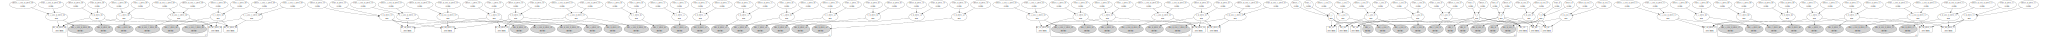

In [33]:
pm.model_to_graphviz(model)

In [34]:
with model:
    samples = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha0_A, alpha0_B, alpha0_C, alpha0_D, beta0_A, beta0_B, beta0_C, beta0_D, p_A, p_B, p_C, p_D, alpha0_A_given_B0, alpha0_A_given_C0, alpha0_A_given_D0, alpha0_B_given_A0, alpha0_B_given_C0, alpha0_B_given_D0, alpha0_C_given_A0, alpha0_C_given_B0, alpha0_C_given_D0, alpha0_D_given_A0, alpha0_D_given_B0, alpha0_D_given_C0, beta0_A_given_B0, beta0_A_given_C0, beta0_A_given_D0, beta0_B_given_A0, beta0_B_given_C0, beta0_B_given_D0, beta0_C_given_A0, beta0_C_given_B0, beta0_C_given_D0, beta0_D_given_A0, beta0_D_given_B0, beta0_D_given_C0, p_A_given_B0, p_A_given_C0, p_A_given_D0, p_B_given_A0, p_B_given_C0, p_B_given_D0, p_C_given_A0, p_C_given_B0, p_C_given_D0, p_D_given_A0, p_D_given_B0, p_D_given_C0, alpha0_A_given_B1, alpha0_A_given_C1, alpha0_A_given_D1, alpha0_B_given_A1, alpha0_B_given_C1, alpha0_B_given_D1, alpha0_C_given_A1, alpha0_C_given_B1, alpha0_C_given

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 442 seconds.


In [36]:
with open('data_0125_1800.pickle', 'wb') as f:
    pickle.dump(samples, f)

In [3]:
with open('data_0125_1800.pickle', 'rb') as f:
    samples = pickle.load(f)

In [4]:
samples_p_A = samples.posterior.p_A.values[:,500:].ravel()
samples_p_B = samples.posterior.p_B.values[:,500:].ravel()
samples_p_C = samples.posterior.p_C.values[:,500:].ravel()
samples_p_D = samples.posterior.p_D.values[:,500:].ravel()

samples_p_A_given_B0 = samples.posterior.p_A_given_B0.values[:,500:].ravel()
samples_p_A_given_C0 = samples.posterior.p_A_given_C0.values[:,500:].ravel()
samples_p_A_given_D0 = samples.posterior.p_A_given_D0.values[:,500:].ravel()
samples_p_B_given_A0 = samples.posterior.p_B_given_A0.values[:,500:].ravel()
samples_p_B_given_C0 = samples.posterior.p_B_given_C0.values[:,500:].ravel()
samples_p_B_given_D0 = samples.posterior.p_B_given_D0.values[:,500:].ravel()
samples_p_C_given_A0 = samples.posterior.p_C_given_A0.values[:,500:].ravel()
samples_p_C_given_B0 = samples.posterior.p_C_given_B0.values[:,500:].ravel()
samples_p_C_given_D0 = samples.posterior.p_C_given_D0.values[:,500:].ravel()
samples_p_D_given_A0 = samples.posterior.p_D_given_A0.values[:,500:].ravel()
samples_p_D_given_B0 = samples.posterior.p_D_given_B0.values[:,500:].ravel()
samples_p_D_given_C0 = samples.posterior.p_D_given_C0.values[:,500:].ravel()

samples_p_A_given_B1 = samples.posterior.p_A_given_B1.values[:,500:].ravel()
samples_p_A_given_C1 = samples.posterior.p_A_given_C1.values[:,500:].ravel()
samples_p_A_given_D1 = samples.posterior.p_A_given_D1.values[:,500:].ravel()
samples_p_B_given_A1 = samples.posterior.p_B_given_A1.values[:,500:].ravel()
samples_p_B_given_C1 = samples.posterior.p_B_given_C1.values[:,500:].ravel()
samples_p_B_given_D1 = samples.posterior.p_B_given_D1.values[:,500:].ravel()
samples_p_C_given_A1 = samples.posterior.p_C_given_A1.values[:,500:].ravel()
samples_p_C_given_B1 = samples.posterior.p_C_given_B1.values[:,500:].ravel()
samples_p_C_given_D1 = samples.posterior.p_C_given_D1.values[:,500:].ravel()
samples_p_D_given_A1 = samples.posterior.p_D_given_A1.values[:,500:].ravel()
samples_p_D_given_B1 = samples.posterior.p_D_given_B1.values[:,500:].ravel()
samples_p_D_given_C1 = samples.posterior.p_D_given_C1.values[:,500:].ravel()

samples_p_A_and_B = samples.posterior.p_A_and_B.values[:,500:].ravel()
samples_p_A_and_C = samples.posterior.p_A_and_C.values[:,500:].ravel()
samples_p_A_and_D = samples.posterior.p_A_and_D.values[:,500:].ravel()
samples_p_B_and_C = samples.posterior.p_B_and_C.values[:,500:].ravel()
samples_p_B_and_D = samples.posterior.p_B_and_D.values[:,500:].ravel()
samples_p_C_and_D = samples.posterior.p_C_and_D.values[:,500:].ravel()

samples_p_A_and_B_given_C0 = samples.posterior.p_A_and_B_given_C0.values[:,500:].ravel()
samples_p_A_and_D_given_C0 = samples.posterior.p_A_and_D_given_C0.values[:,500:].ravel()
samples_p_B_and_D_given_C0 = samples.posterior.p_B_and_D_given_C0.values[:,500:].ravel()
samples_p_A_and_B_given_C1 = samples.posterior.p_A_and_B_given_C1.values[:,500:].ravel()
samples_p_A_and_D_given_C1 = samples.posterior.p_A_and_D_given_C1.values[:,500:].ravel()
samples_p_B_and_D_given_C1 = samples.posterior.p_B_and_D_given_C1.values[:,500:].ravel()
samples_p_A_and_B_given_D0 = samples.posterior.p_A_and_B_given_D0.values[:,500:].ravel()
samples_p_A_and_C_given_D0 = samples.posterior.p_A_and_C_given_D0.values[:,500:].ravel()
samples_p_B_and_C_given_D0 = samples.posterior.p_B_and_C_given_D0.values[:,500:].ravel()
samples_p_A_and_B_given_D1 = samples.posterior.p_A_and_B_given_D1.values[:,500:].ravel()
samples_p_A_and_C_given_D1 = samples.posterior.p_A_and_C_given_D1.values[:,500:].ravel()
samples_p_B_and_C_given_D1 = samples.posterior.p_B_and_C_given_D1.values[:,500:].ravel()

In [5]:
samples_ind_AB = samples.posterior.ind_AB.values[:,500:].ravel()
samples_ind_AC = samples.posterior.ind_AC.values[:,500:].ravel()
samples_ind_AD = samples.posterior.ind_AD.values[:,500:].ravel()
samples_ind_BC = samples.posterior.ind_BC.values[:,500:].ravel()
samples_ind_BD = samples.posterior.ind_BD.values[:,500:].ravel()
samples_ind_CD = samples.posterior.ind_CD.values[:,500:].ravel()

samples_ind_AB_given_C0 = samples.posterior.ind_AB_given_C0.values[:,500:].ravel()
samples_ind_AB_given_C1 = samples.posterior.ind_AB_given_C1.values[:,500:].ravel()
samples_ind_AD_given_C0 = samples.posterior.ind_AD_given_C0.values[:,500:].ravel()
samples_ind_AD_given_C1 = samples.posterior.ind_AD_given_C1.values[:,500:].ravel()
samples_ind_BD_given_C0 = samples.posterior.ind_BD_given_C0.values[:,500:].ravel()
samples_ind_BD_given_C1 = samples.posterior.ind_BD_given_C1.values[:,500:].ravel()
samples_ind_AB_given_D0 = samples.posterior.ind_AB_given_D0.values[:,500:].ravel()
samples_ind_AB_given_D1 = samples.posterior.ind_AB_given_D1.values[:,500:].ravel()
samples_ind_AC_given_D0 = samples.posterior.ind_AC_given_D0.values[:,500:].ravel()
samples_ind_AC_given_D1 = samples.posterior.ind_AC_given_D1.values[:,500:].ravel()
samples_ind_BC_given_D0 = samples.posterior.ind_BC_given_D0.values[:,500:].ravel()
samples_ind_BC_given_D1 = samples.posterior.ind_BC_given_D1.values[:,500:].ravel()

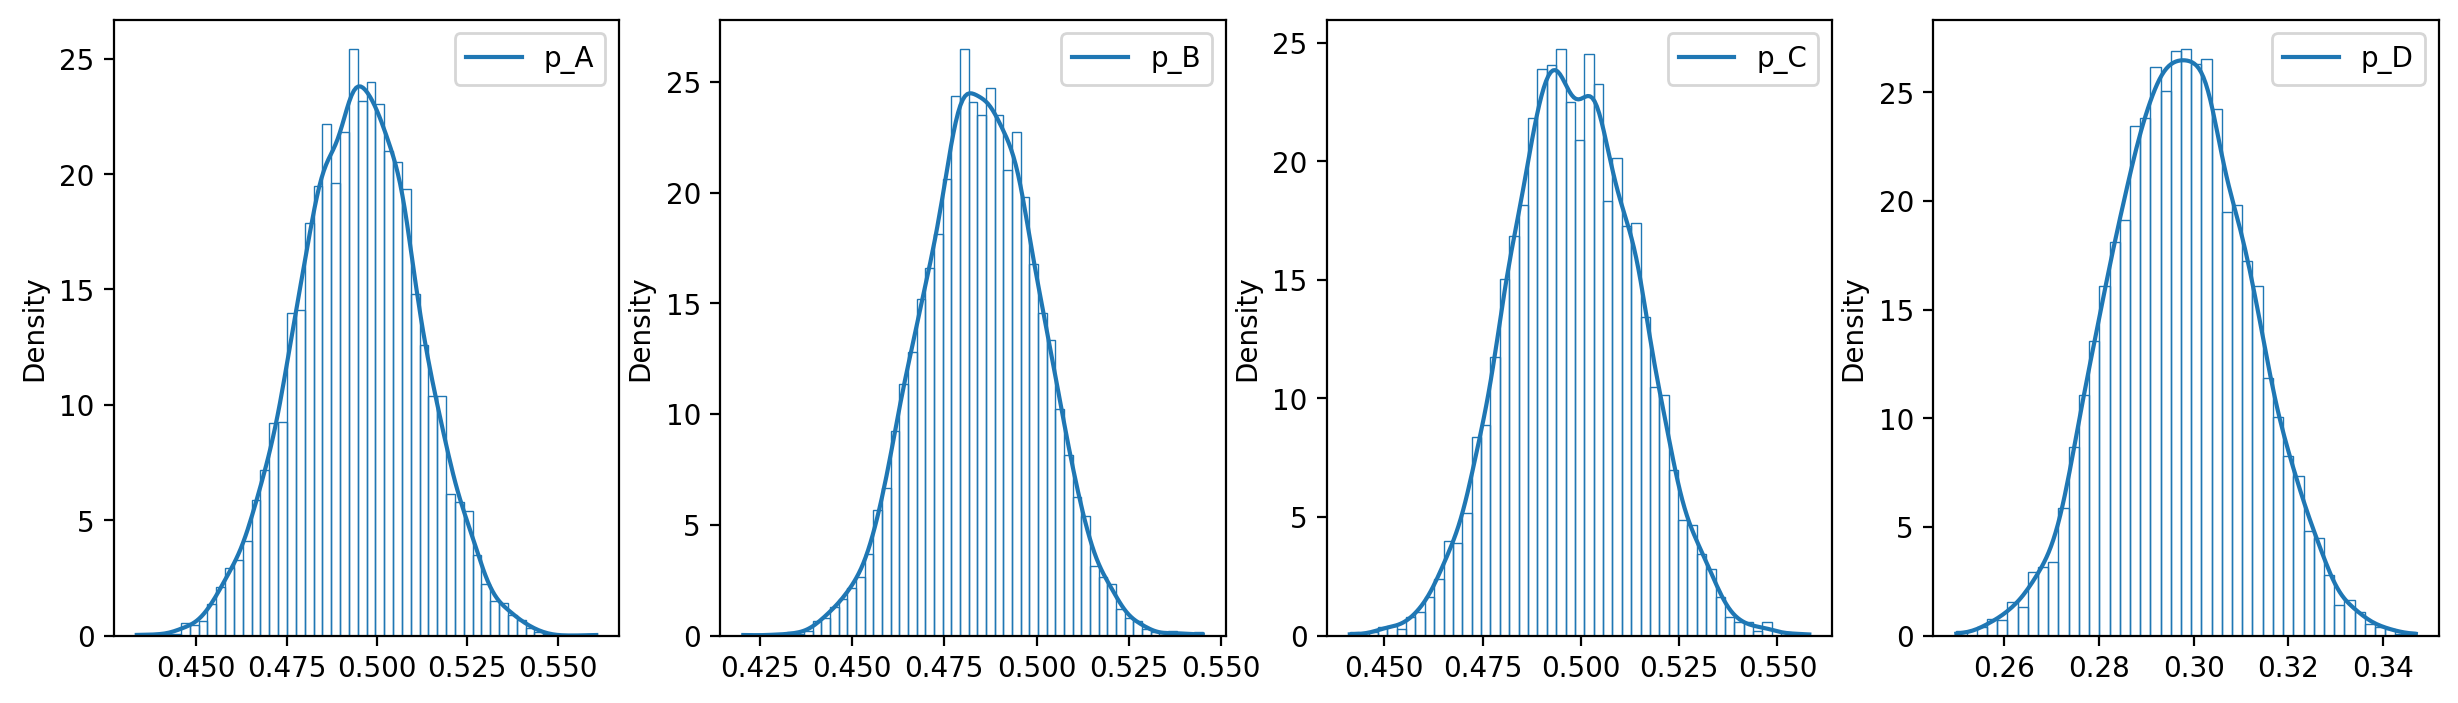

In [7]:
# STEP 1 : Check independence between maginal distributions. 
fix, ax = plt.subplots(1,4, figsize = (15,4))

sns.histplot(abs(samples_p_A), kde=True, ax=ax[0], fill= False, stat = "density");
sns.histplot(abs(samples_p_B), kde=True, ax=ax[1], fill= False, stat = "density");
sns.histplot(abs(samples_p_C), kde=True, ax=ax[2], fill= False, stat = "density");
sns.histplot(abs(samples_p_D), kde=True, ax=ax[3], fill= False, stat = "density");

ax[0].legend(["p_A"])
ax[1].legend(["p_B"])
ax[2].legend(["p_C"])
ax[3].legend(["p_D"])

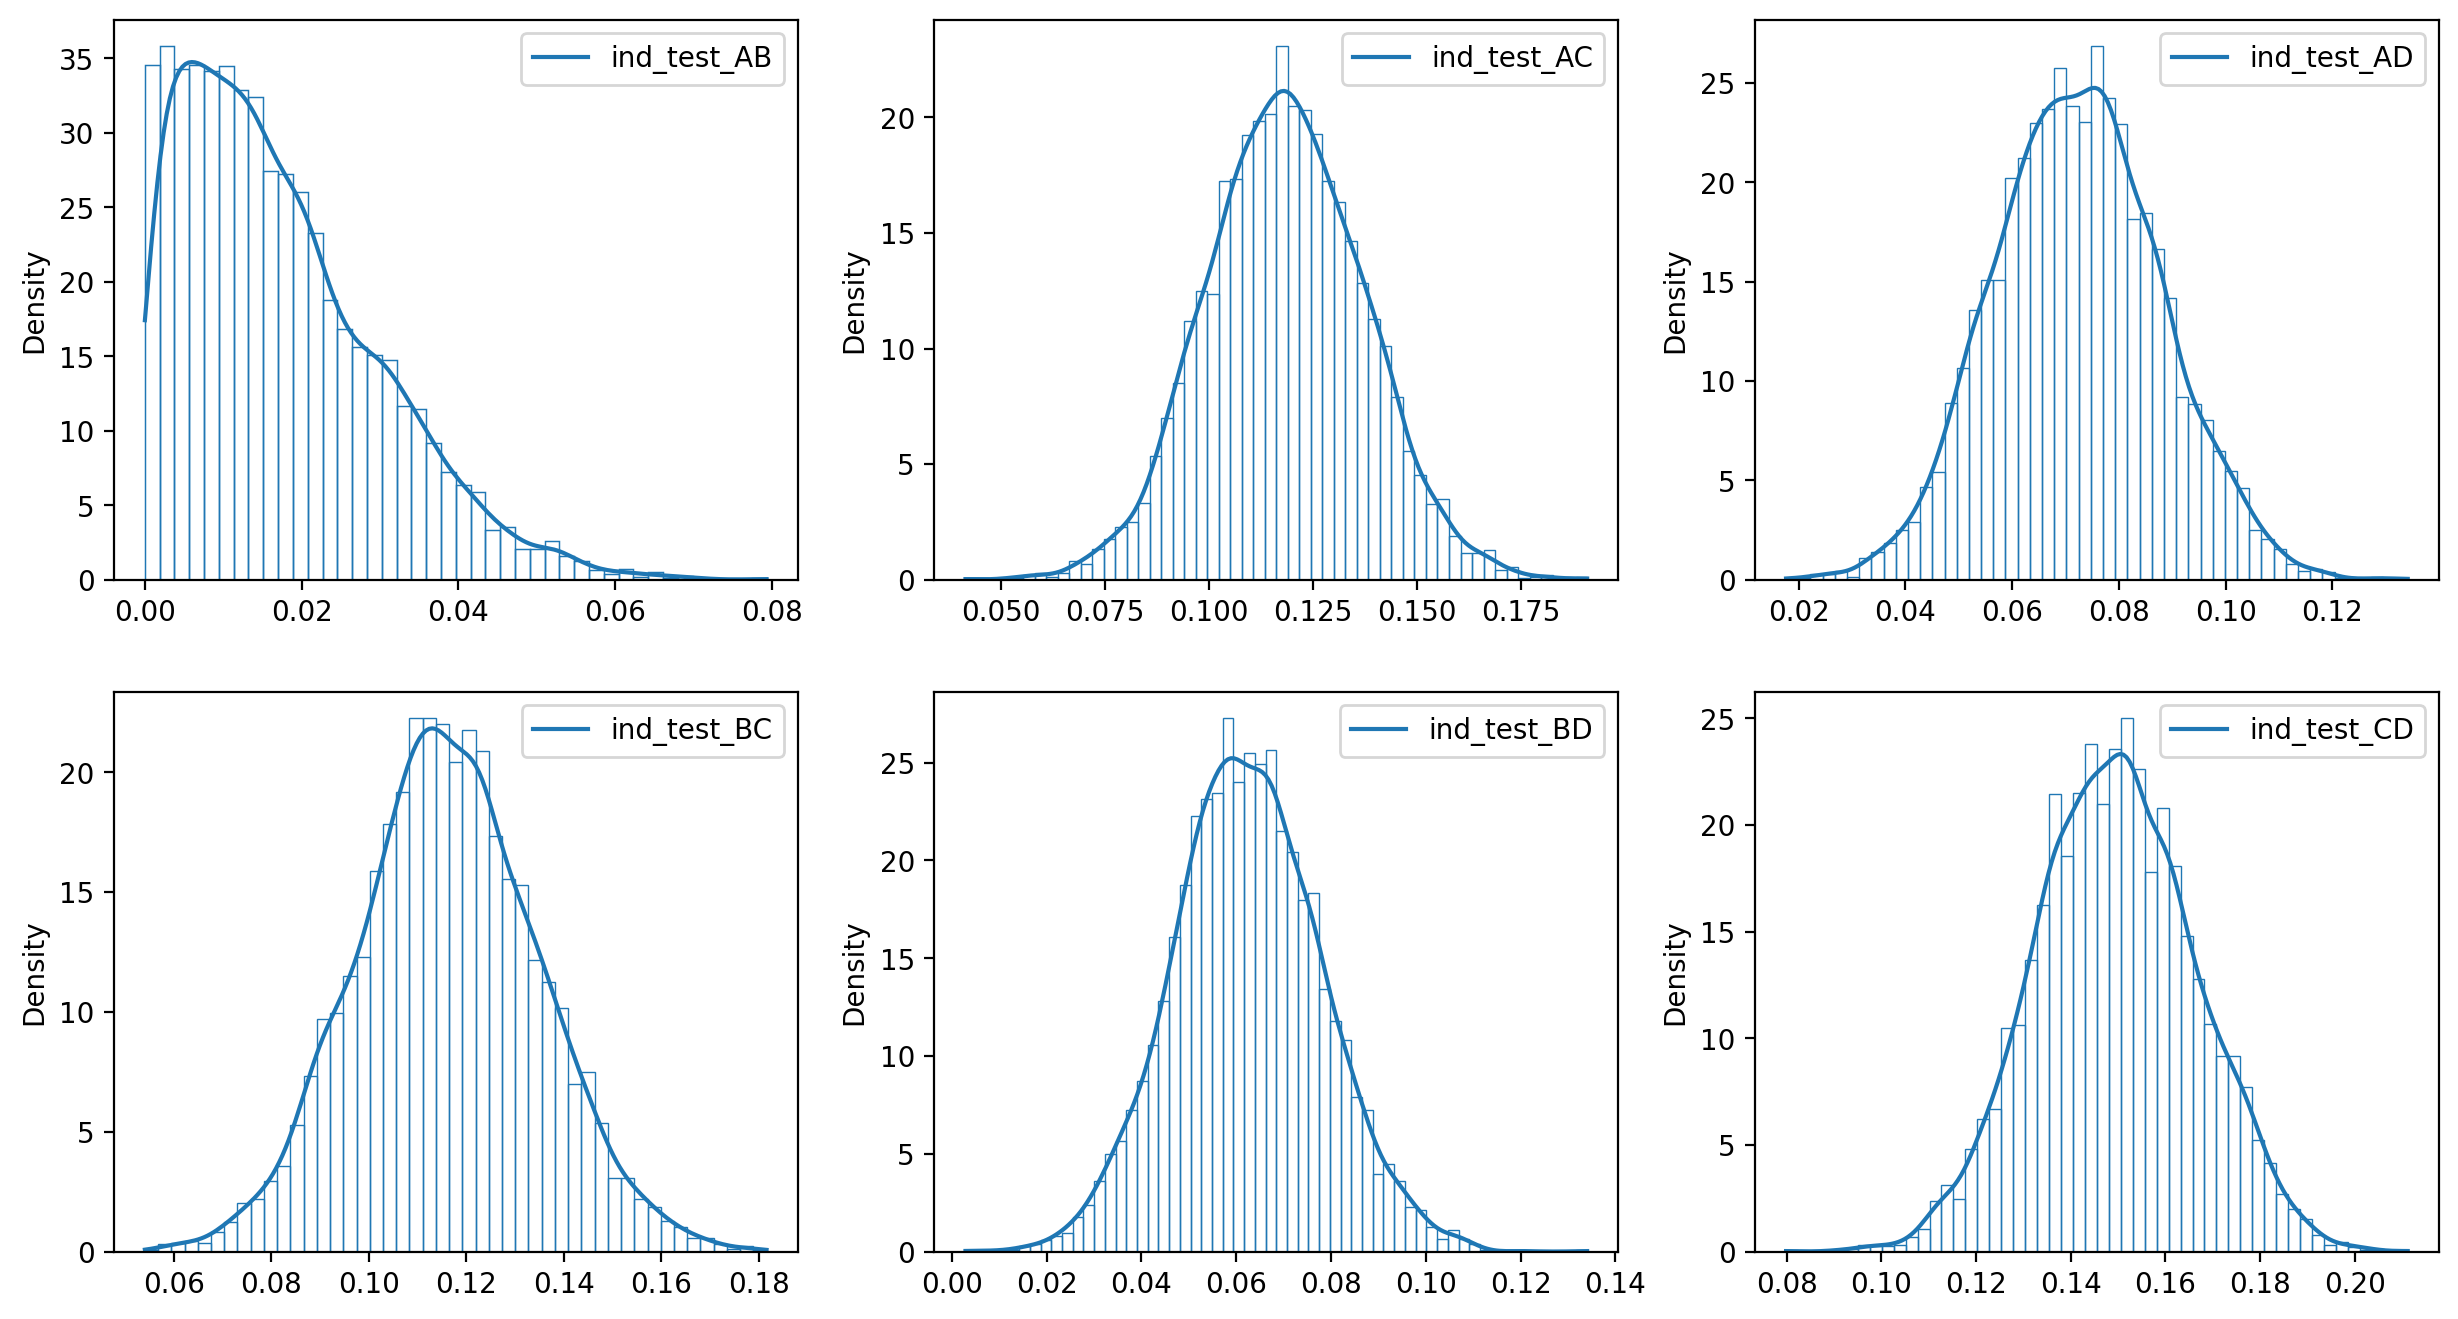

In [39]:
# STEP 1 : Check independence between maginal distributions. 
fix, ax = plt.subplots(2,3, figsize = (15,8))

sns.histplot(abs(samples_ind_AB), kde=True, ax=ax[0,0], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AC), kde=True, ax=ax[0,1], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AD), kde=True, ax=ax[0,2], fill= False, stat = "density");
sns.histplot(abs(samples_ind_BC), kde=True, ax=ax[1,0], fill= False, stat = "density");
sns.histplot(abs(samples_ind_BD), kde=True, ax=ax[1,1], fill= False, stat = "density");
sns.histplot(abs(samples_ind_CD), kde=True, ax=ax[1,2], fill= False, stat = "density");

ax[0,0].legend(["ind_test_AB"])
ax[0,1].legend(["ind_test_AC"])
ax[0,2].legend(["ind_test_AD"])
ax[1,0].legend(["ind_test_BC"])
ax[1,1].legend(["ind_test_BD"])
ax[1,2].legend(["ind_test_CD"])

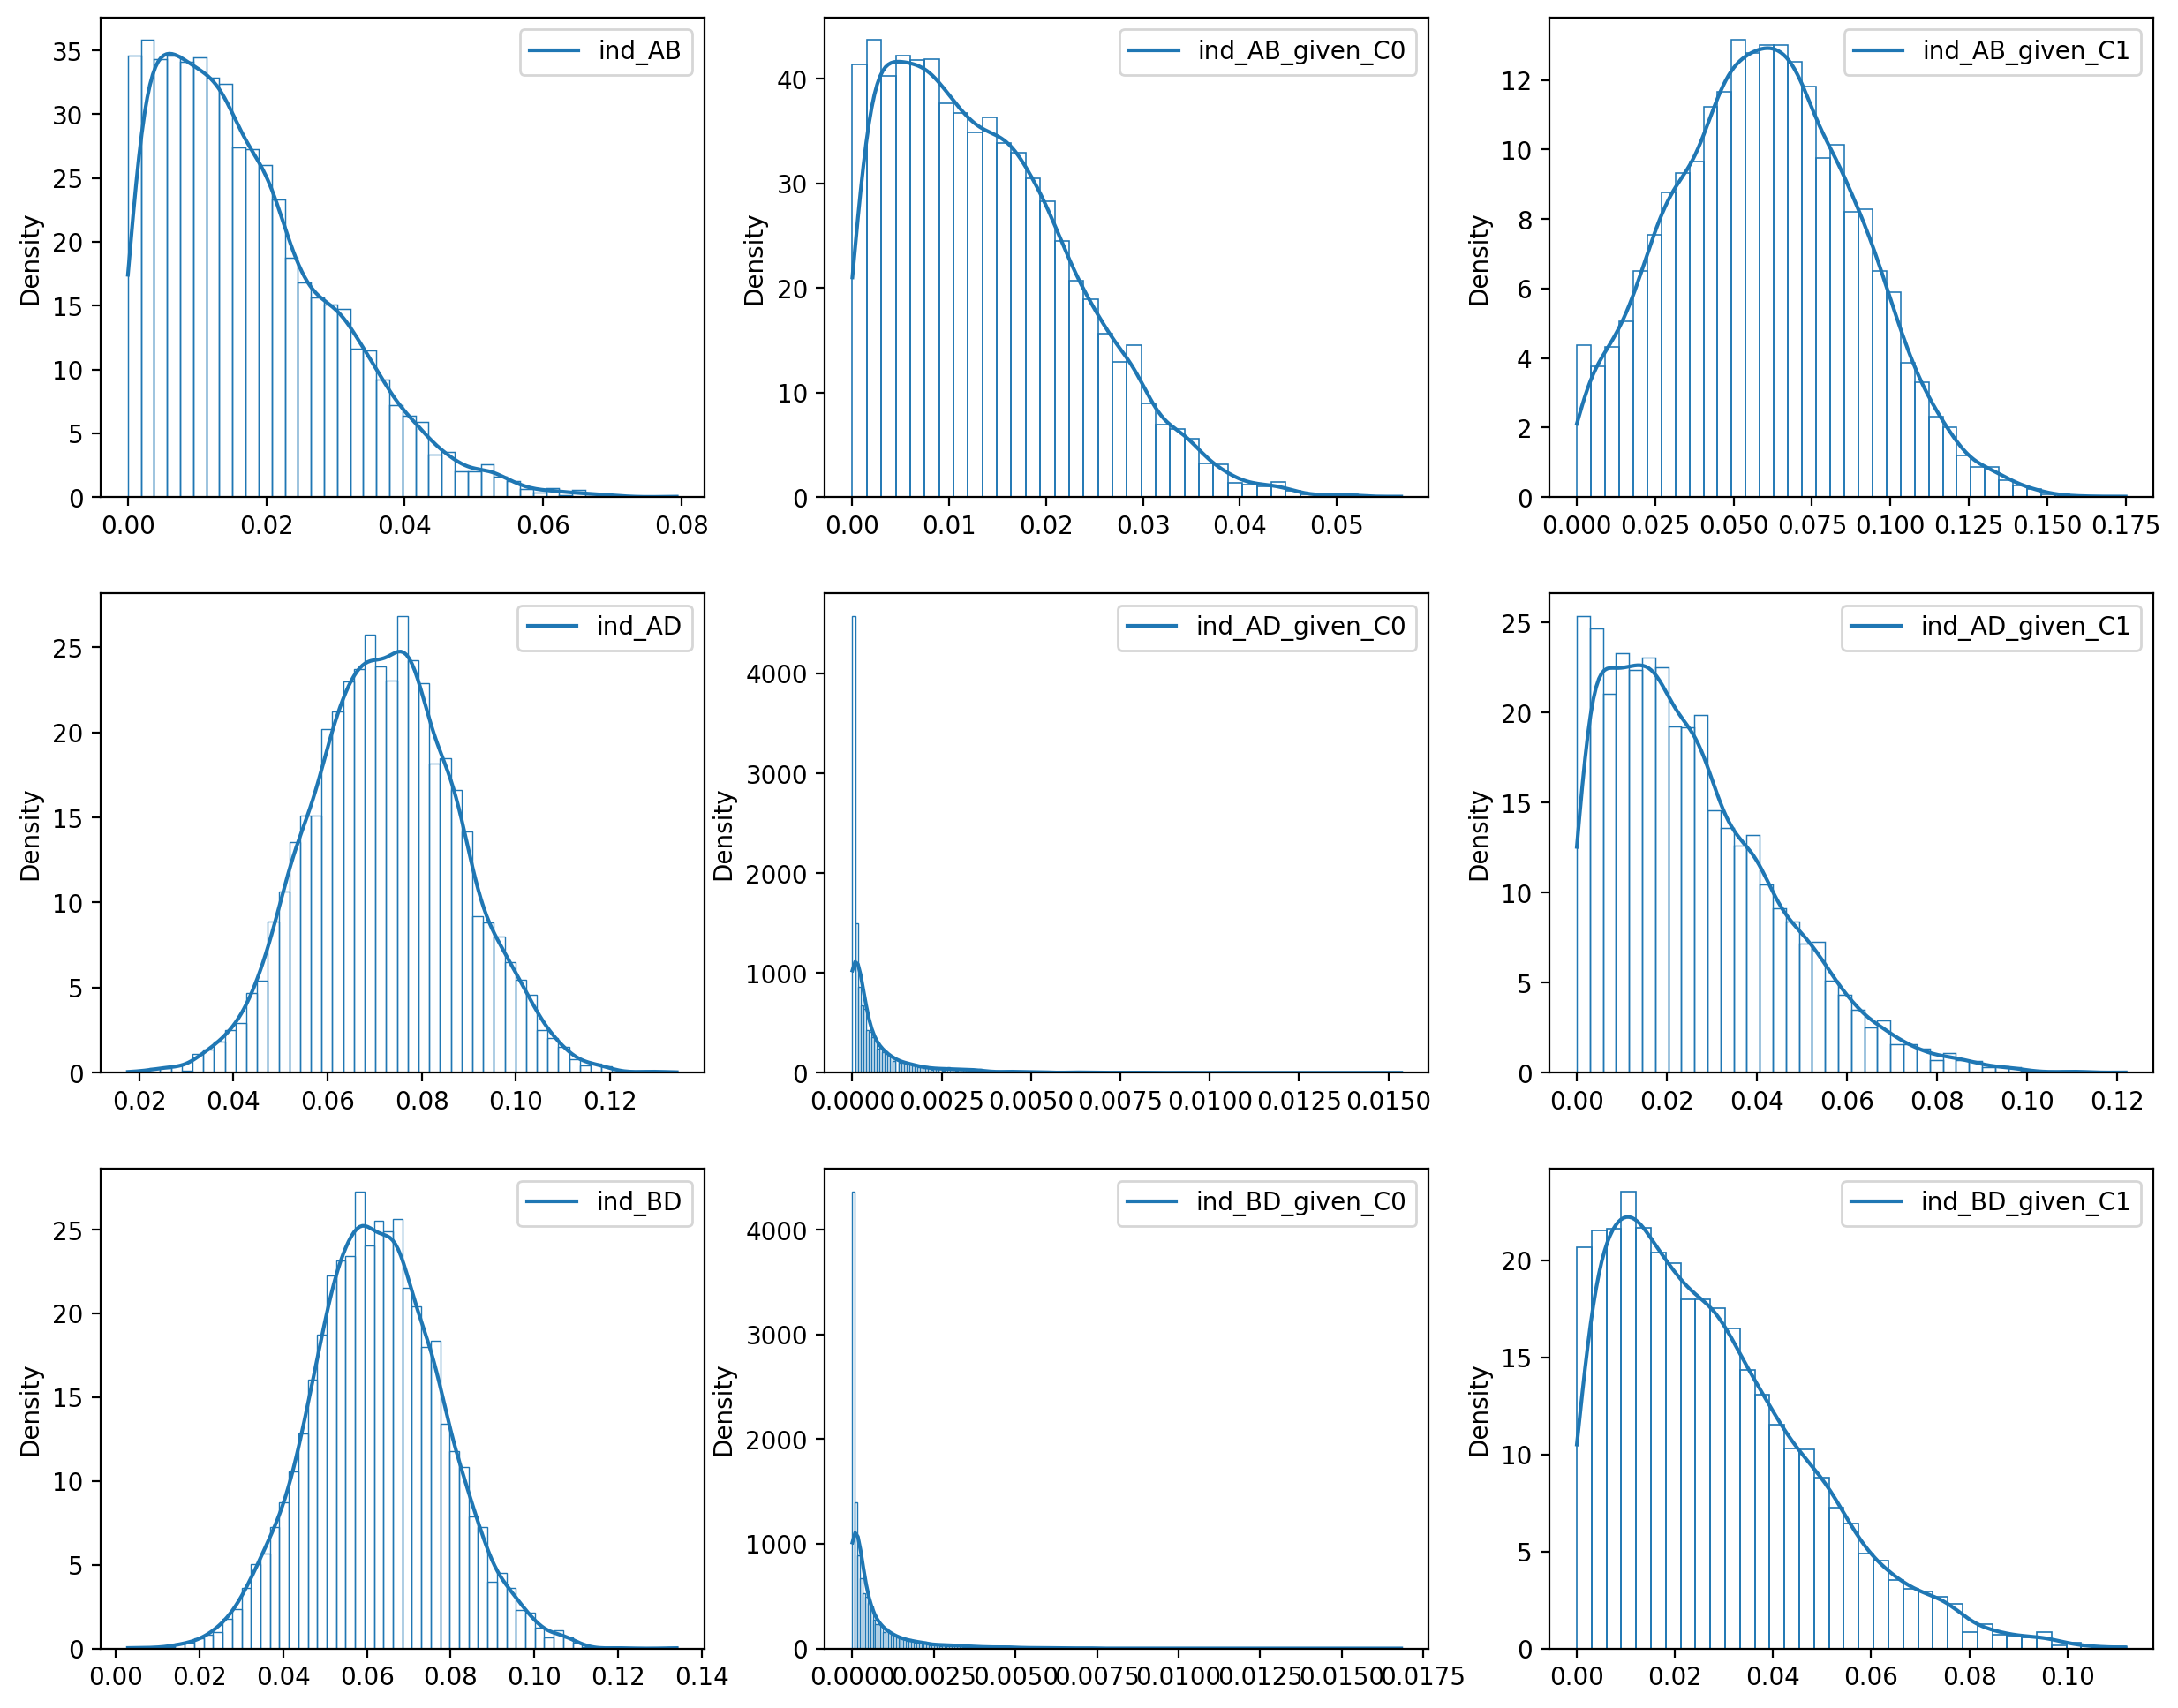

In [43]:
# STEP 2 : Check independence between conditional distributions. 

fix, ax = plt.subplots(3,3, figsize = (15,12))

sns.histplot(abs(samples_ind_AB), kde=True, ax=ax[0,0], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AB_given_C0), kde=True, ax=ax[0,1], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AB_given_C1), kde=True, ax=ax[0,2], fill= False, stat = "density");

sns.histplot(abs(samples_ind_AD), kde=True, ax=ax[1,0], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AD_given_C0), kde=True, ax=ax[1,1], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AD_given_C1), kde=True, ax=ax[1,2], fill= False, stat = "density");

sns.histplot(abs(samples_ind_BD), kde=True, ax=ax[2,0], fill= False, stat = "density");
sns.histplot(abs(samples_ind_BD_given_C0), kde=True, ax=ax[2,1], fill= False, stat = "density");
sns.histplot(abs(samples_ind_BD_given_C1), kde=True, ax=ax[2,2], fill= False, stat = "density");

ax[0,0].legend(["ind_AB"])
ax[0,1].legend(["ind_AB_given_C0"])
ax[0,2].legend(["ind_AB_given_C1"])
ax[1,0].legend(["ind_AD"])
ax[1,1].legend(["ind_AD_given_C0"])
ax[1,2].legend(["ind_AD_given_C1"])
ax[2,0].legend(["ind_BD"])
ax[2,1].legend(["ind_BD_given_C0"])
ax[2,2].legend(["ind_BD_given_C1"])

# for m in [0,1,2]:
#     for n in [0,1,2]:
#         ax[m,n].set_xlim((-0.2,+0.2))

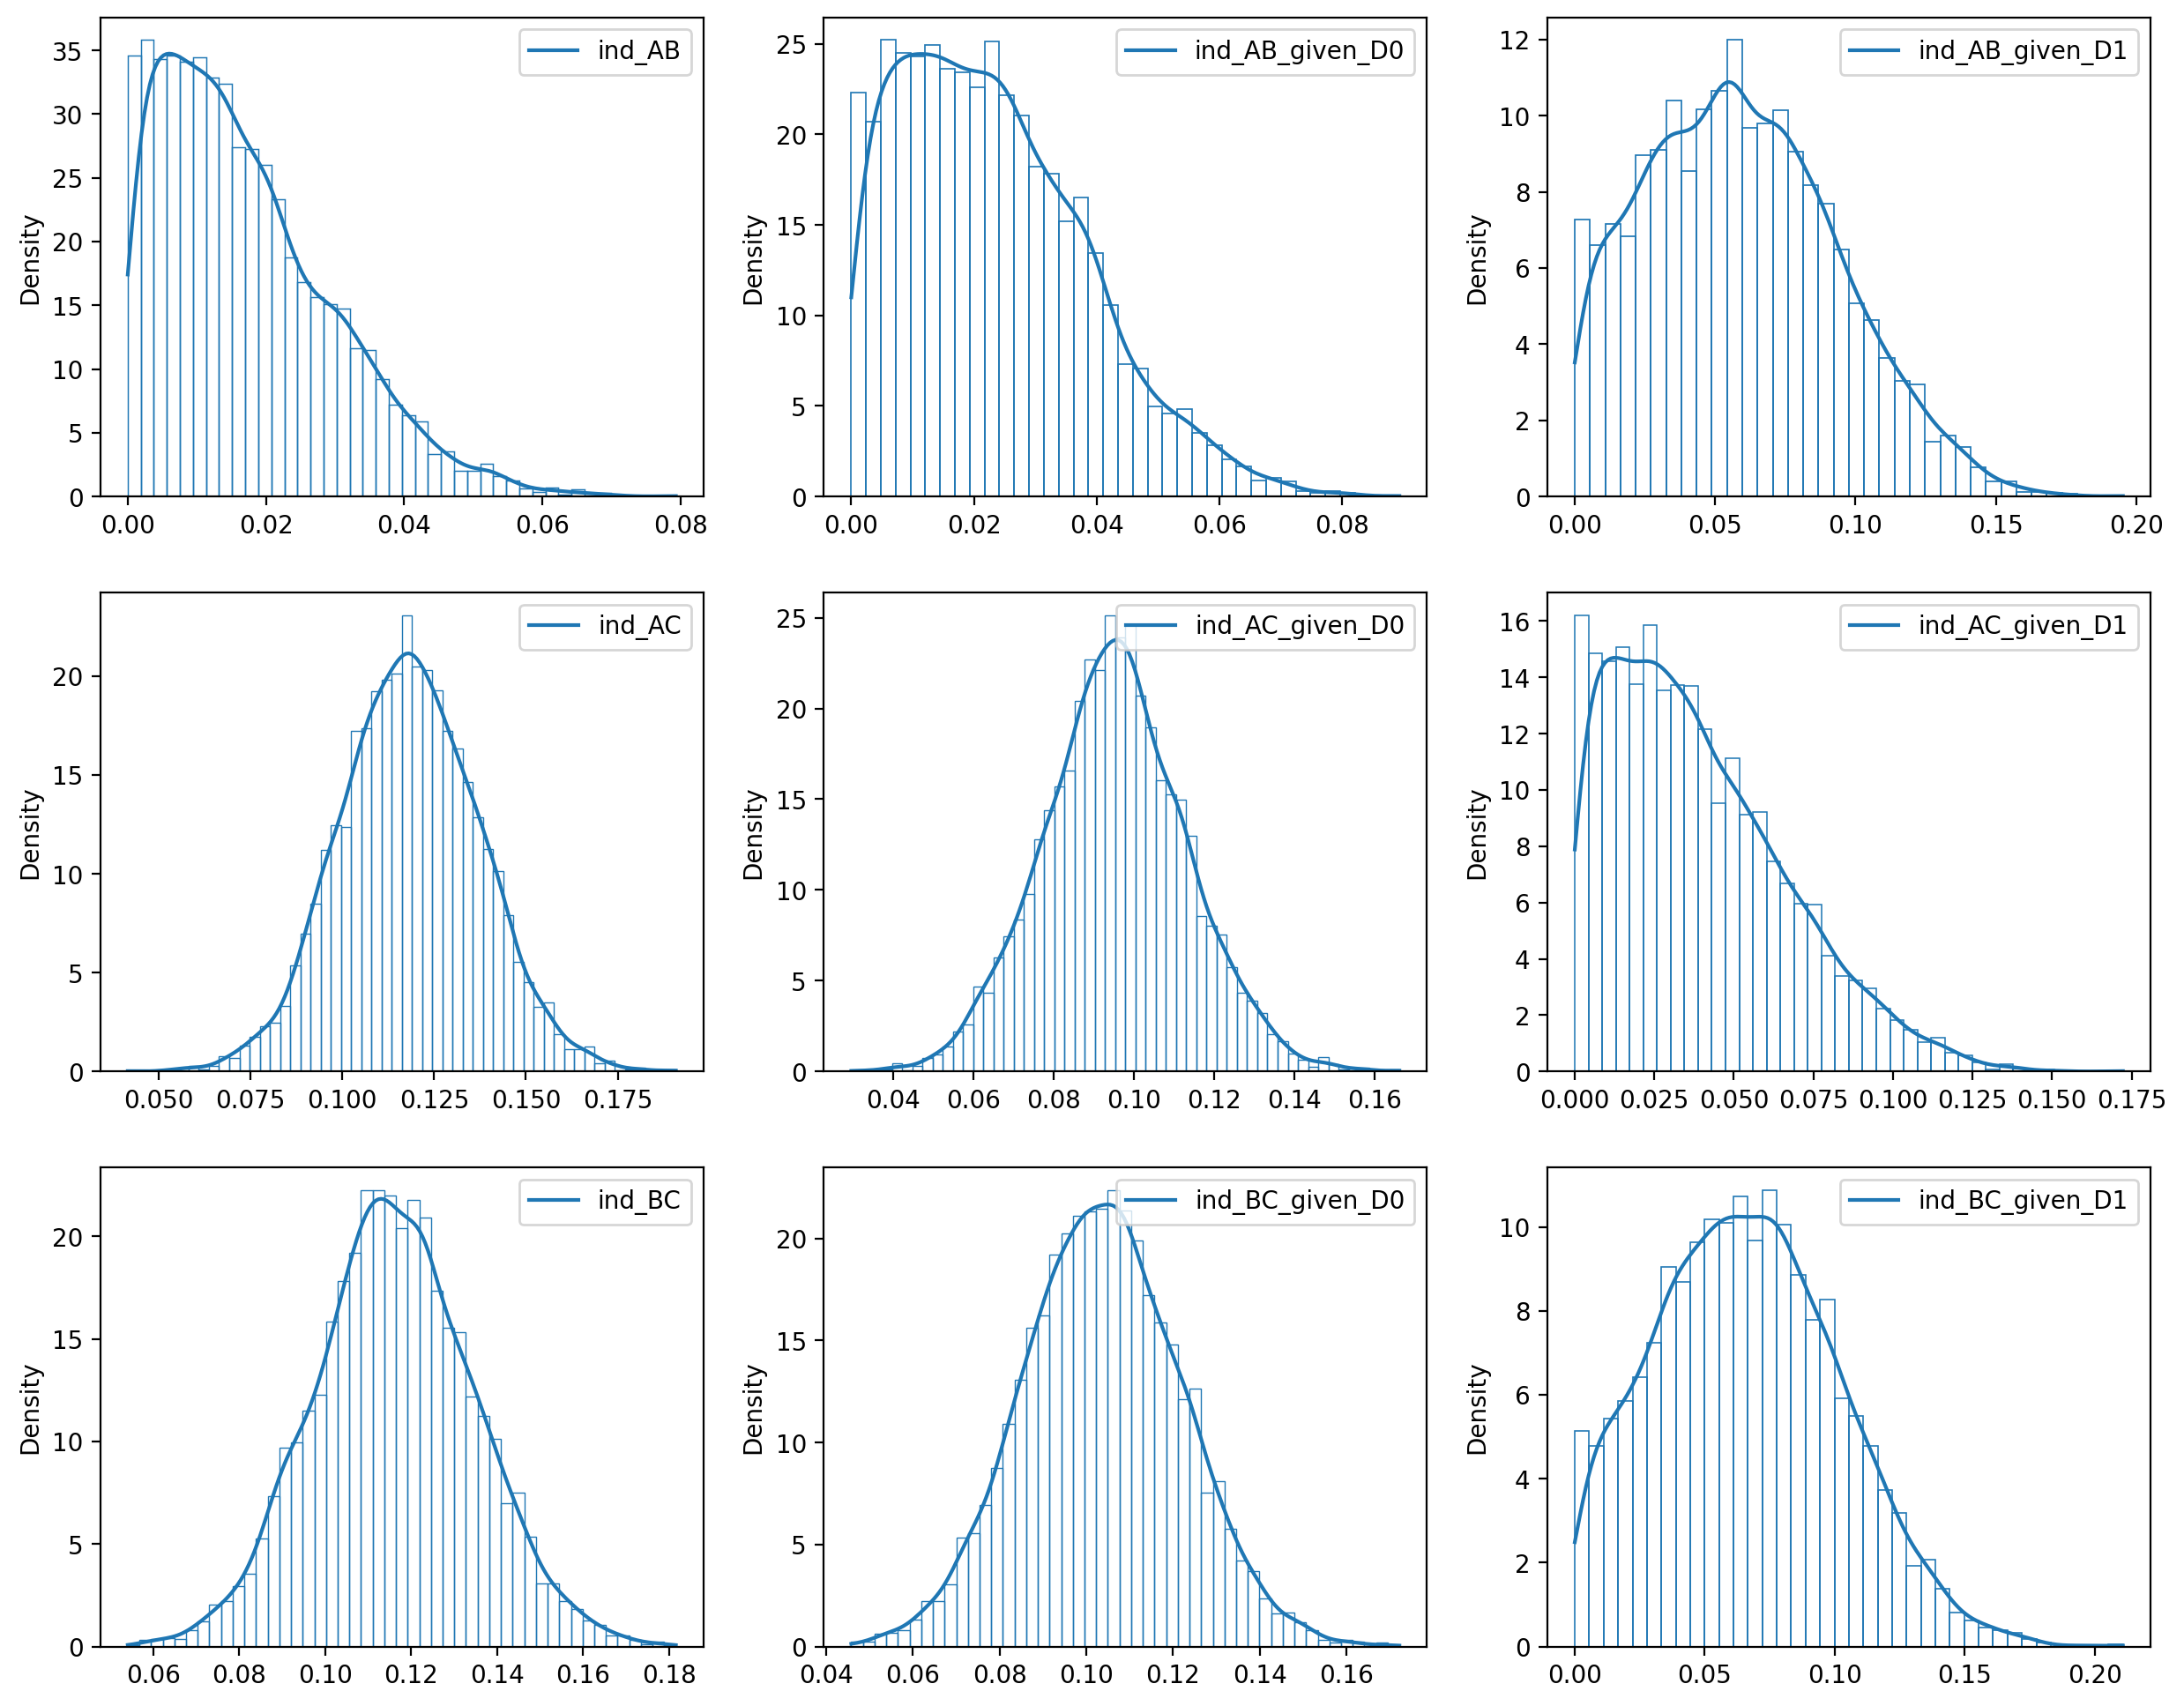

In [44]:
# STEP 2 : Check independence between conditional distributions. 

fix, ax = plt.subplots(3,3, figsize = (15,12))

sns.histplot(abs(samples_ind_AB), kde=True, ax=ax[0,0], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AB_given_D0), kde=True, ax=ax[0,1], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AB_given_D1), kde=True, ax=ax[0,2], fill= False, stat = "density");

sns.histplot(abs(samples_ind_AC), kde=True, ax=ax[1,0], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AC_given_D0), kde=True, ax=ax[1,1], fill= False, stat = "density");
sns.histplot(abs(samples_ind_AC_given_D1), kde=True, ax=ax[1,2], fill= False, stat = "density");

sns.histplot(abs(samples_ind_BC), kde=True, ax=ax[2,0], fill= False, stat = "density");
sns.histplot(abs(samples_ind_BC_given_D0), kde=True, ax=ax[2,1], fill= False, stat = "density");
sns.histplot(abs(samples_ind_BC_given_D1), kde=True, ax=ax[2,2], fill= False, stat = "density");

ax[0,0].legend(["ind_AB"])
ax[0,1].legend(["ind_AB_given_D0"])
ax[0,2].legend(["ind_AB_given_D1"])
ax[1,0].legend(["ind_AC"])
ax[1,1].legend(["ind_AC_given_D0"])
ax[1,2].legend(["ind_AC_given_D1"])
ax[2,0].legend(["ind_BC"])
ax[2,1].legend(["ind_BC_given_D0"])
ax[2,2].legend(["ind_BC_given_D1"])

# for m in [0,1,2]:
#     for n in [0,1,2]:
#         ax[m,n].set_xlim((-0.2,+0.2))

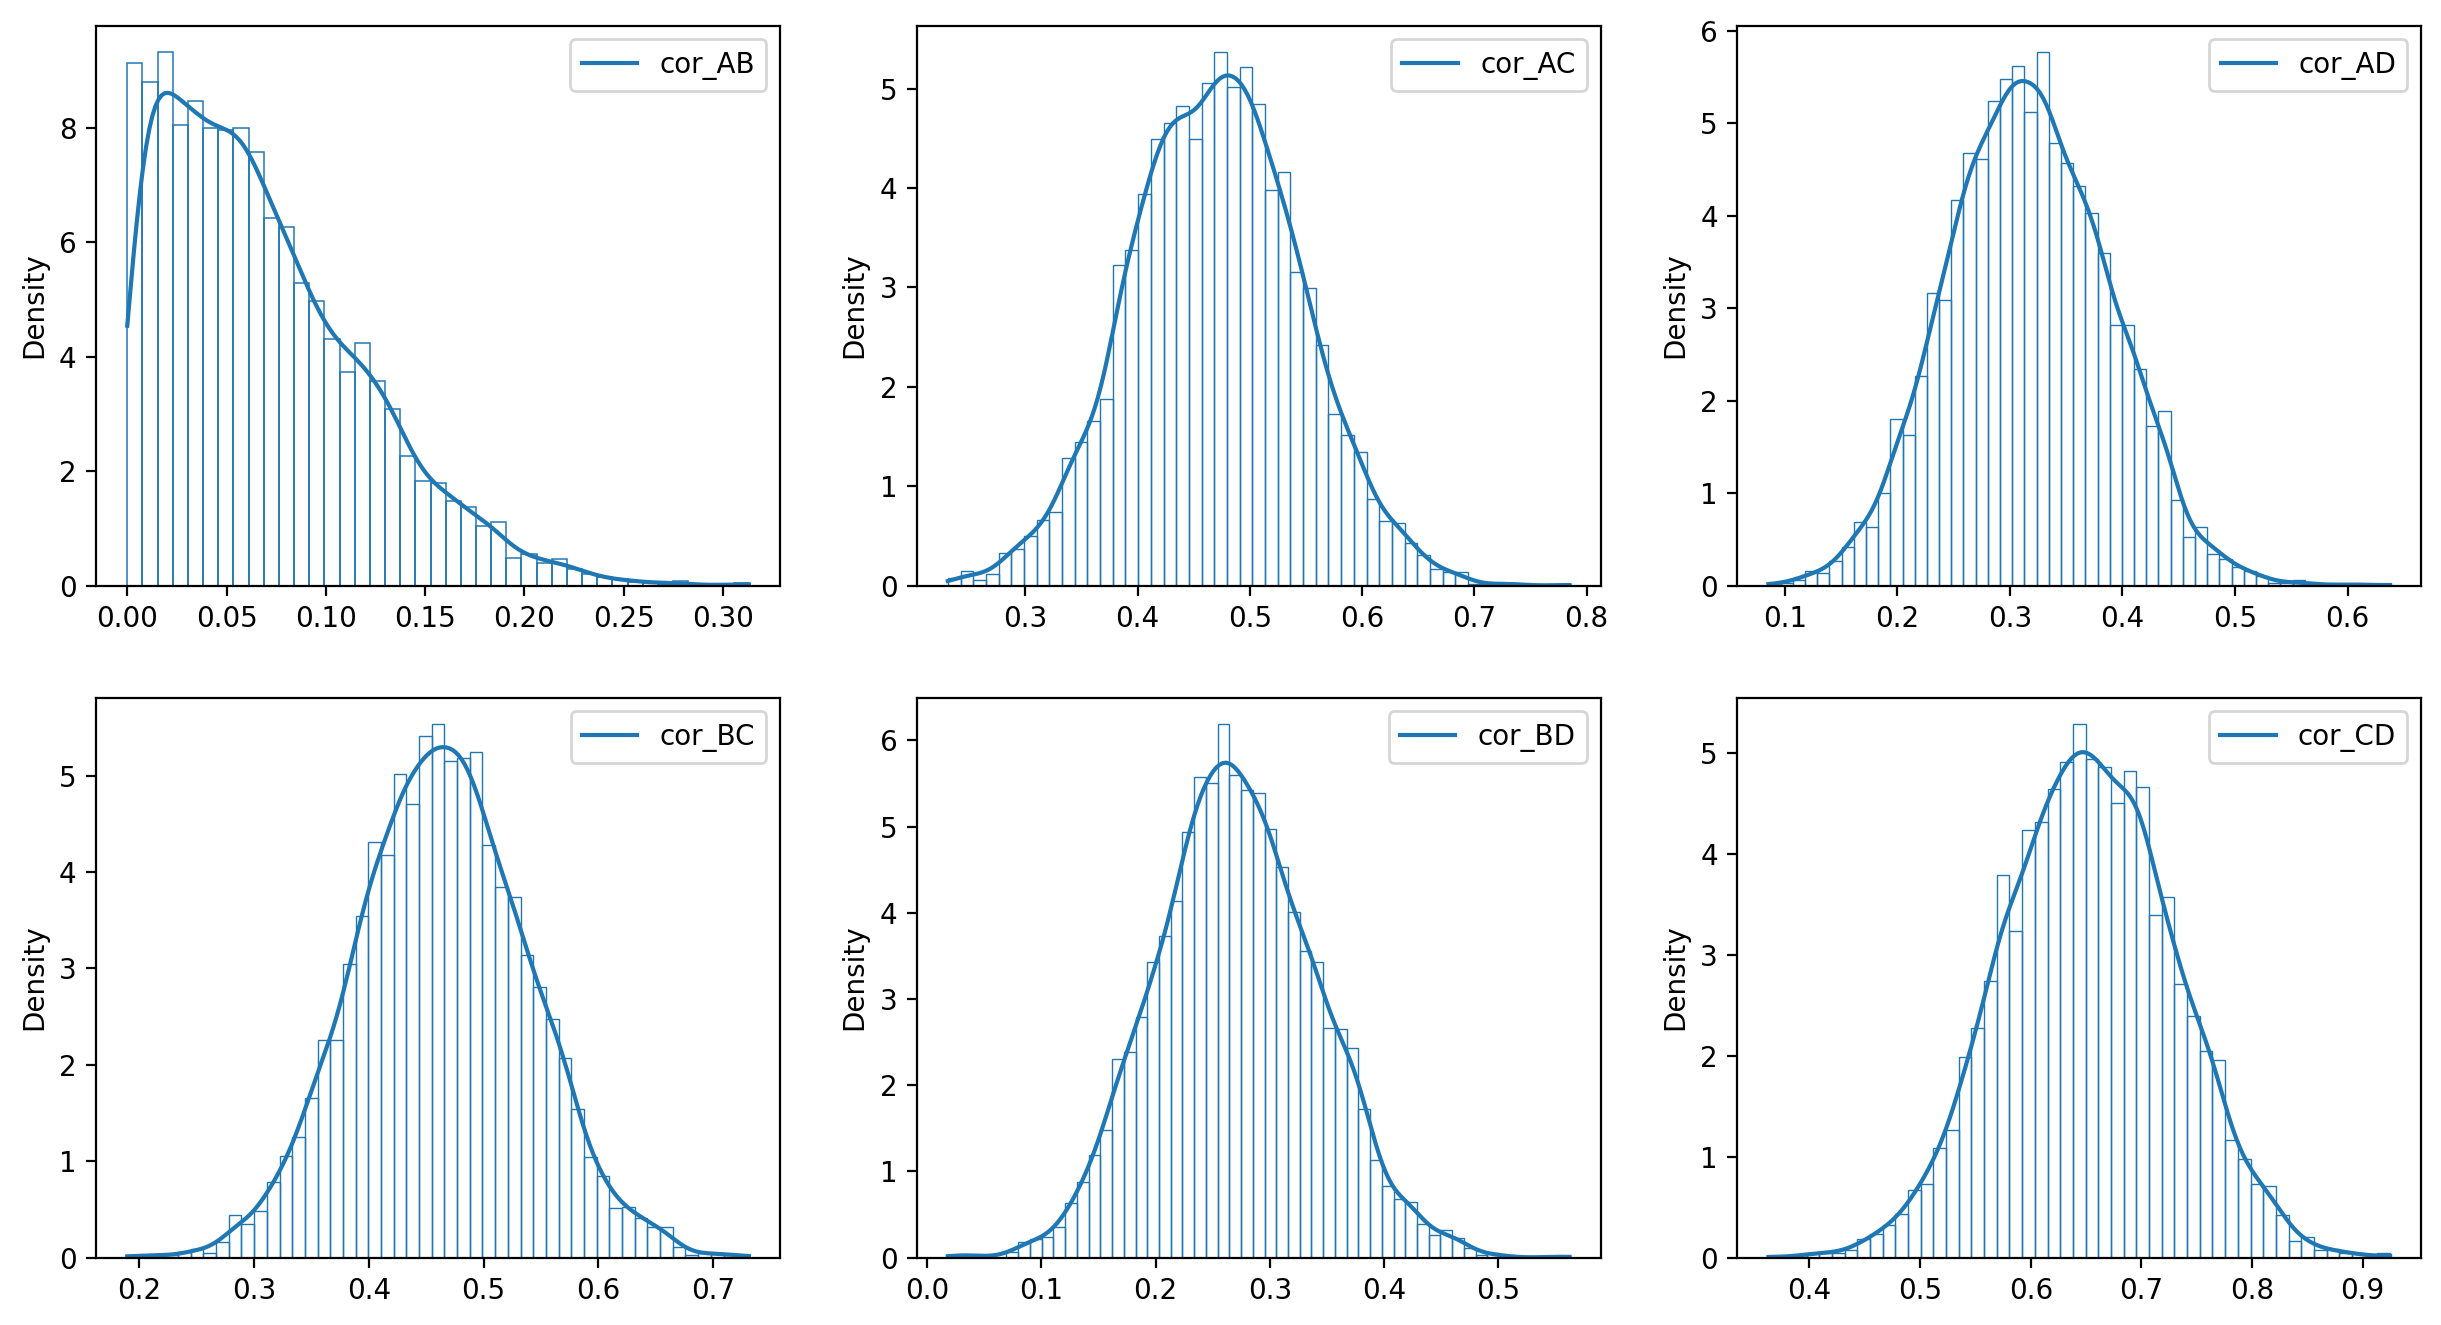

In [30]:
# STEP 1 : Check independence between maginal distributions. 
fix, ax = plt.subplots(2,3, figsize = (15,8))

cor_AB = abs(phi_corr(samples_p_A, samples_p_B, samples_p_A_and_B))
cor_AC = abs(phi_corr(samples_p_A, samples_p_C, samples_p_A_and_C))
cor_AD = abs(phi_corr(samples_p_A, samples_p_D, samples_p_A_and_D))
cor_BC = abs(phi_corr(samples_p_B, samples_p_C, samples_p_B_and_C))
cor_BD = abs(phi_corr(samples_p_B, samples_p_D, samples_p_B_and_D))
cor_CD = abs(phi_corr(samples_p_C, samples_p_D, samples_p_C_and_D))

sns.histplot(cor_AB, kde=True, ax=ax[0,0], fill= False, stat = "density");
sns.histplot(cor_AC, kde=True, ax=ax[0,1], fill= False, stat = "density");
sns.histplot(cor_AD, kde=True, ax=ax[0,2], fill= False, stat = "density");
sns.histplot(cor_BC, kde=True, ax=ax[1,0], fill= False, stat = "density");
sns.histplot(cor_BD, kde=True, ax=ax[1,1], fill= False, stat = "density");
sns.histplot(cor_CD, kde=True, ax=ax[1,2], fill= False, stat = "density");

ax[0,0].legend(["cor_AB"])
ax[0,1].legend(["cor_AC"])
ax[0,2].legend(["cor_AD"])
ax[1,0].legend(["cor_BC"])
ax[1,1].legend(["cor_BD"])
ax[1,2].legend(["cor_CD"])

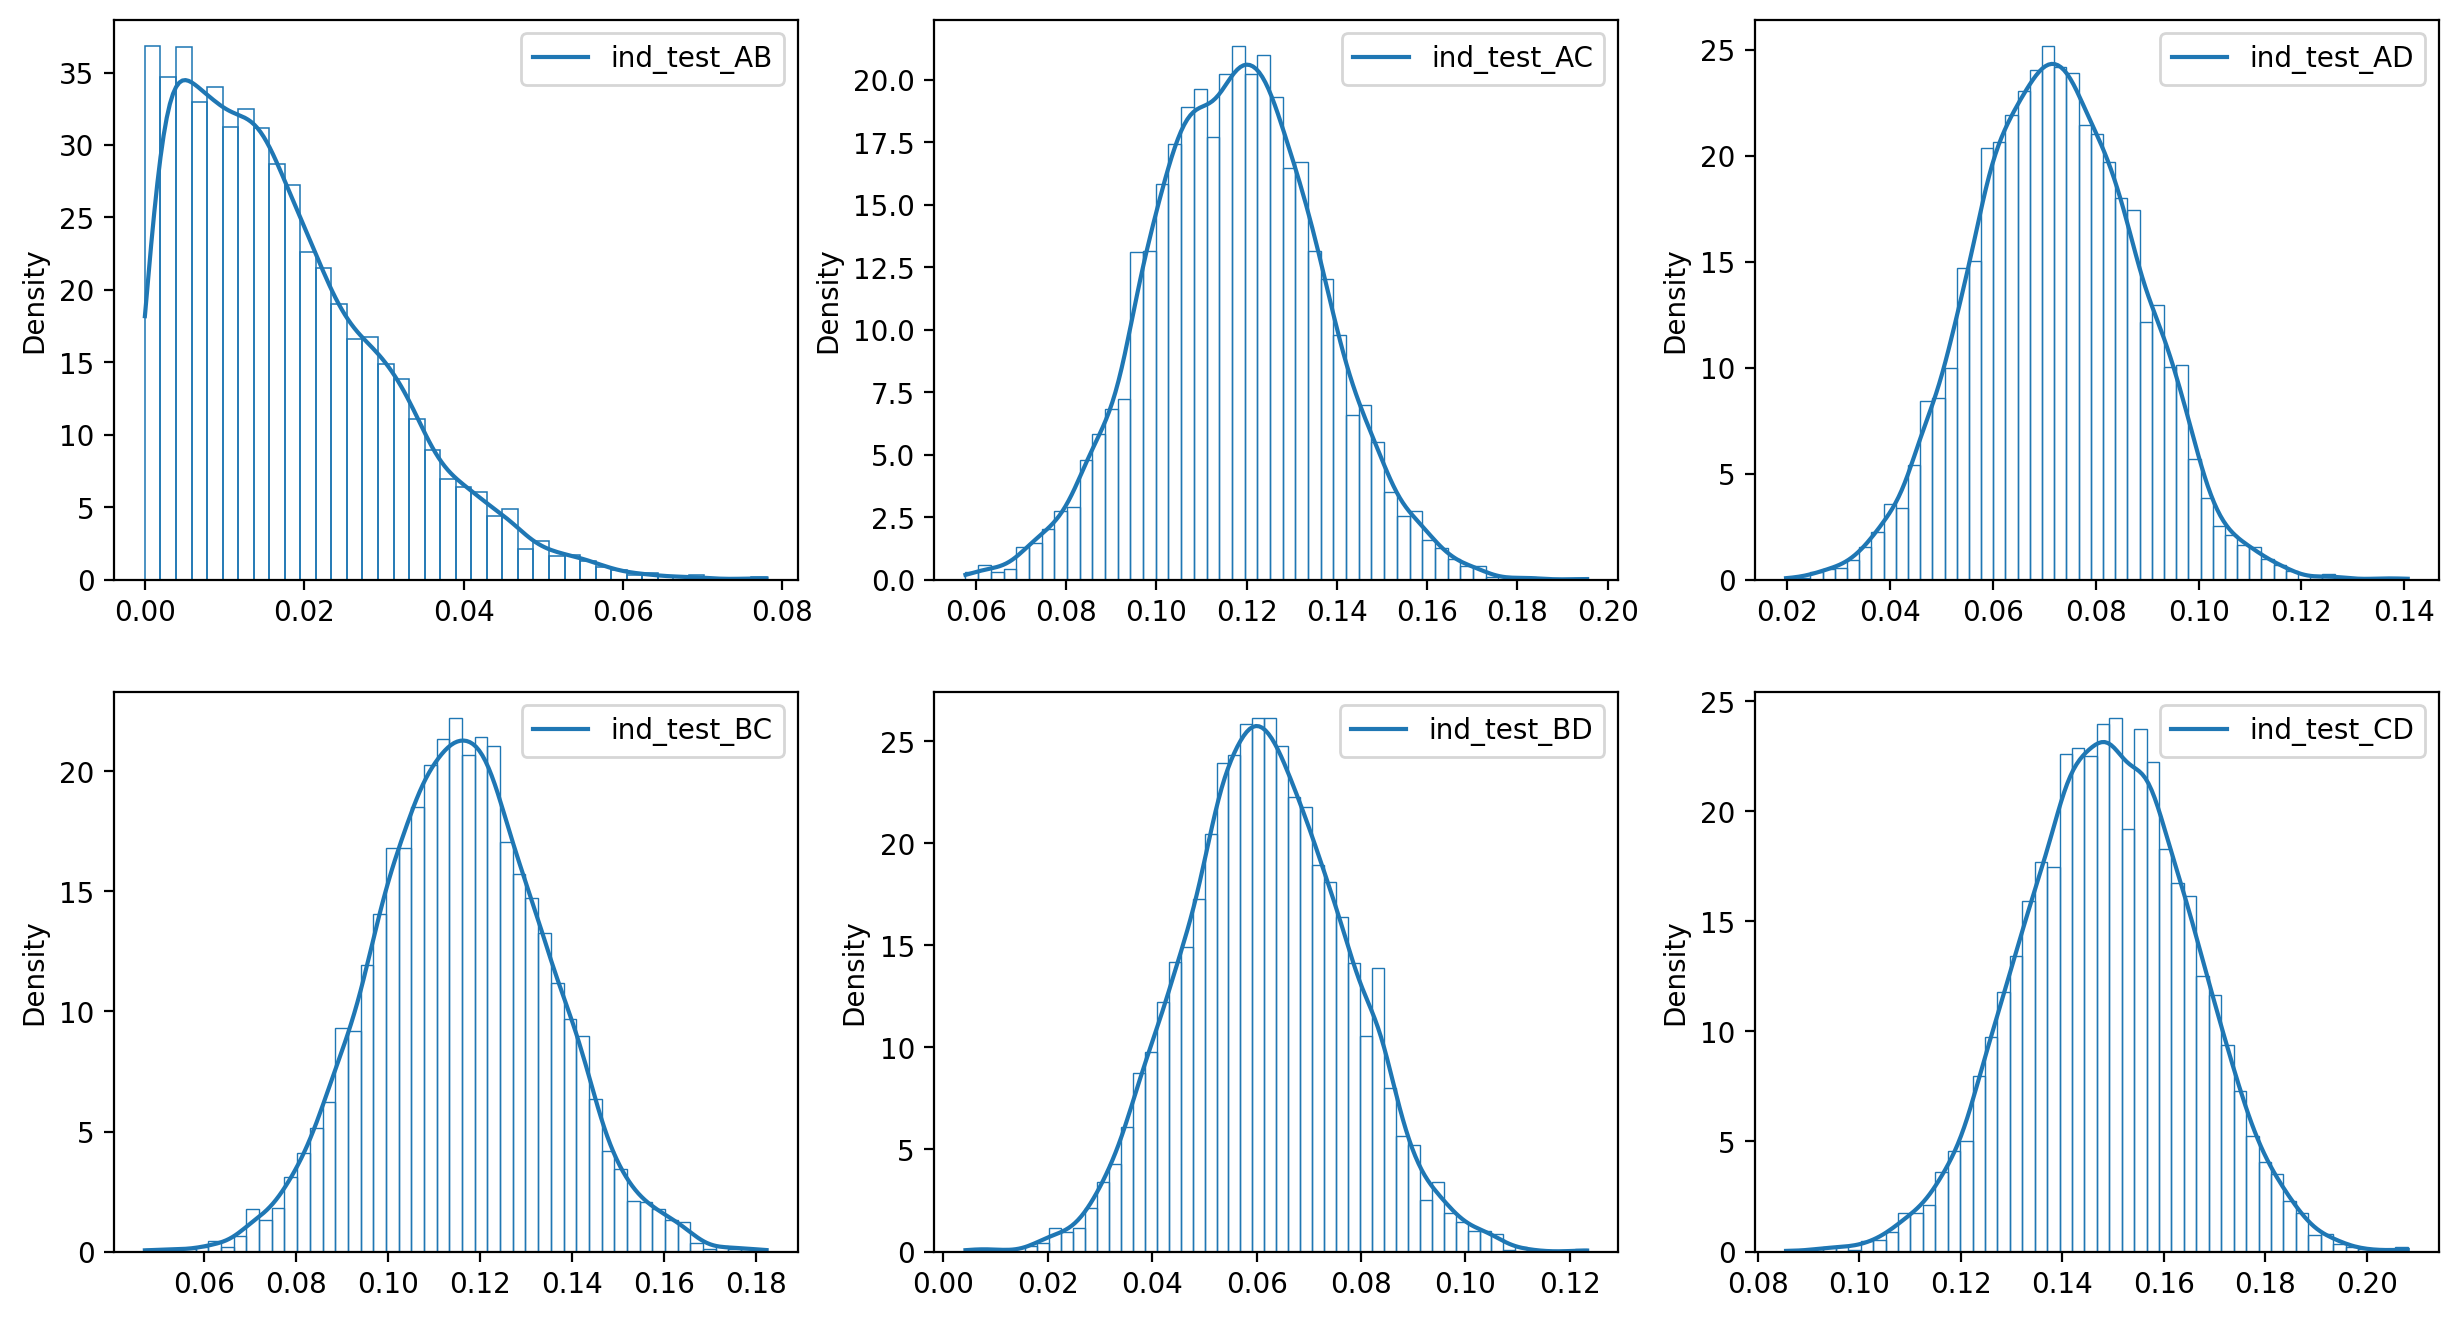

In [28]:
# STEP 1 : Check independence between maginal distributions. 
fix, ax = plt.subplots(2,3, figsize = (15,8))

ind_AB = abs(samples_p_A_and_B-samples_p_A*samples_p_B)
ind_AC = abs(samples_p_A_and_C-samples_p_A*samples_p_C)
ind_AD = abs(samples_p_A_and_D-samples_p_A*samples_p_D)
ind_BC = abs(samples_p_B_and_C-samples_p_B*samples_p_C)
ind_BD = abs(samples_p_B_and_D-samples_p_B*samples_p_D)
ind_CD = abs(samples_p_C_and_D-samples_p_C*samples_p_D)

sns.histplot(ind_AB, kde=True, ax=ax[0,0], fill= False, stat = "density");
sns.histplot(ind_AC, kde=True, ax=ax[0,1], fill= False, stat = "density");
sns.histplot(ind_AD, kde=True, ax=ax[0,2], fill= False, stat = "density");
sns.histplot(ind_BC, kde=True, ax=ax[1,0], fill= False, stat = "density");
sns.histplot(ind_BD, kde=True, ax=ax[1,1], fill= False, stat = "density");
sns.histplot(ind_CD, kde=True, ax=ax[1,2], fill= False, stat = "density");

ax[0,0].legend(["ind_test_AB"])
ax[0,1].legend(["ind_test_AC"])
ax[0,2].legend(["ind_test_AD"])
ax[1,0].legend(["ind_test_BC"])
ax[1,1].legend(["ind_test_BD"])
ax[1,2].legend(["ind_test_CD"])

It seems that there may be no direct/indirect paths between A and B.

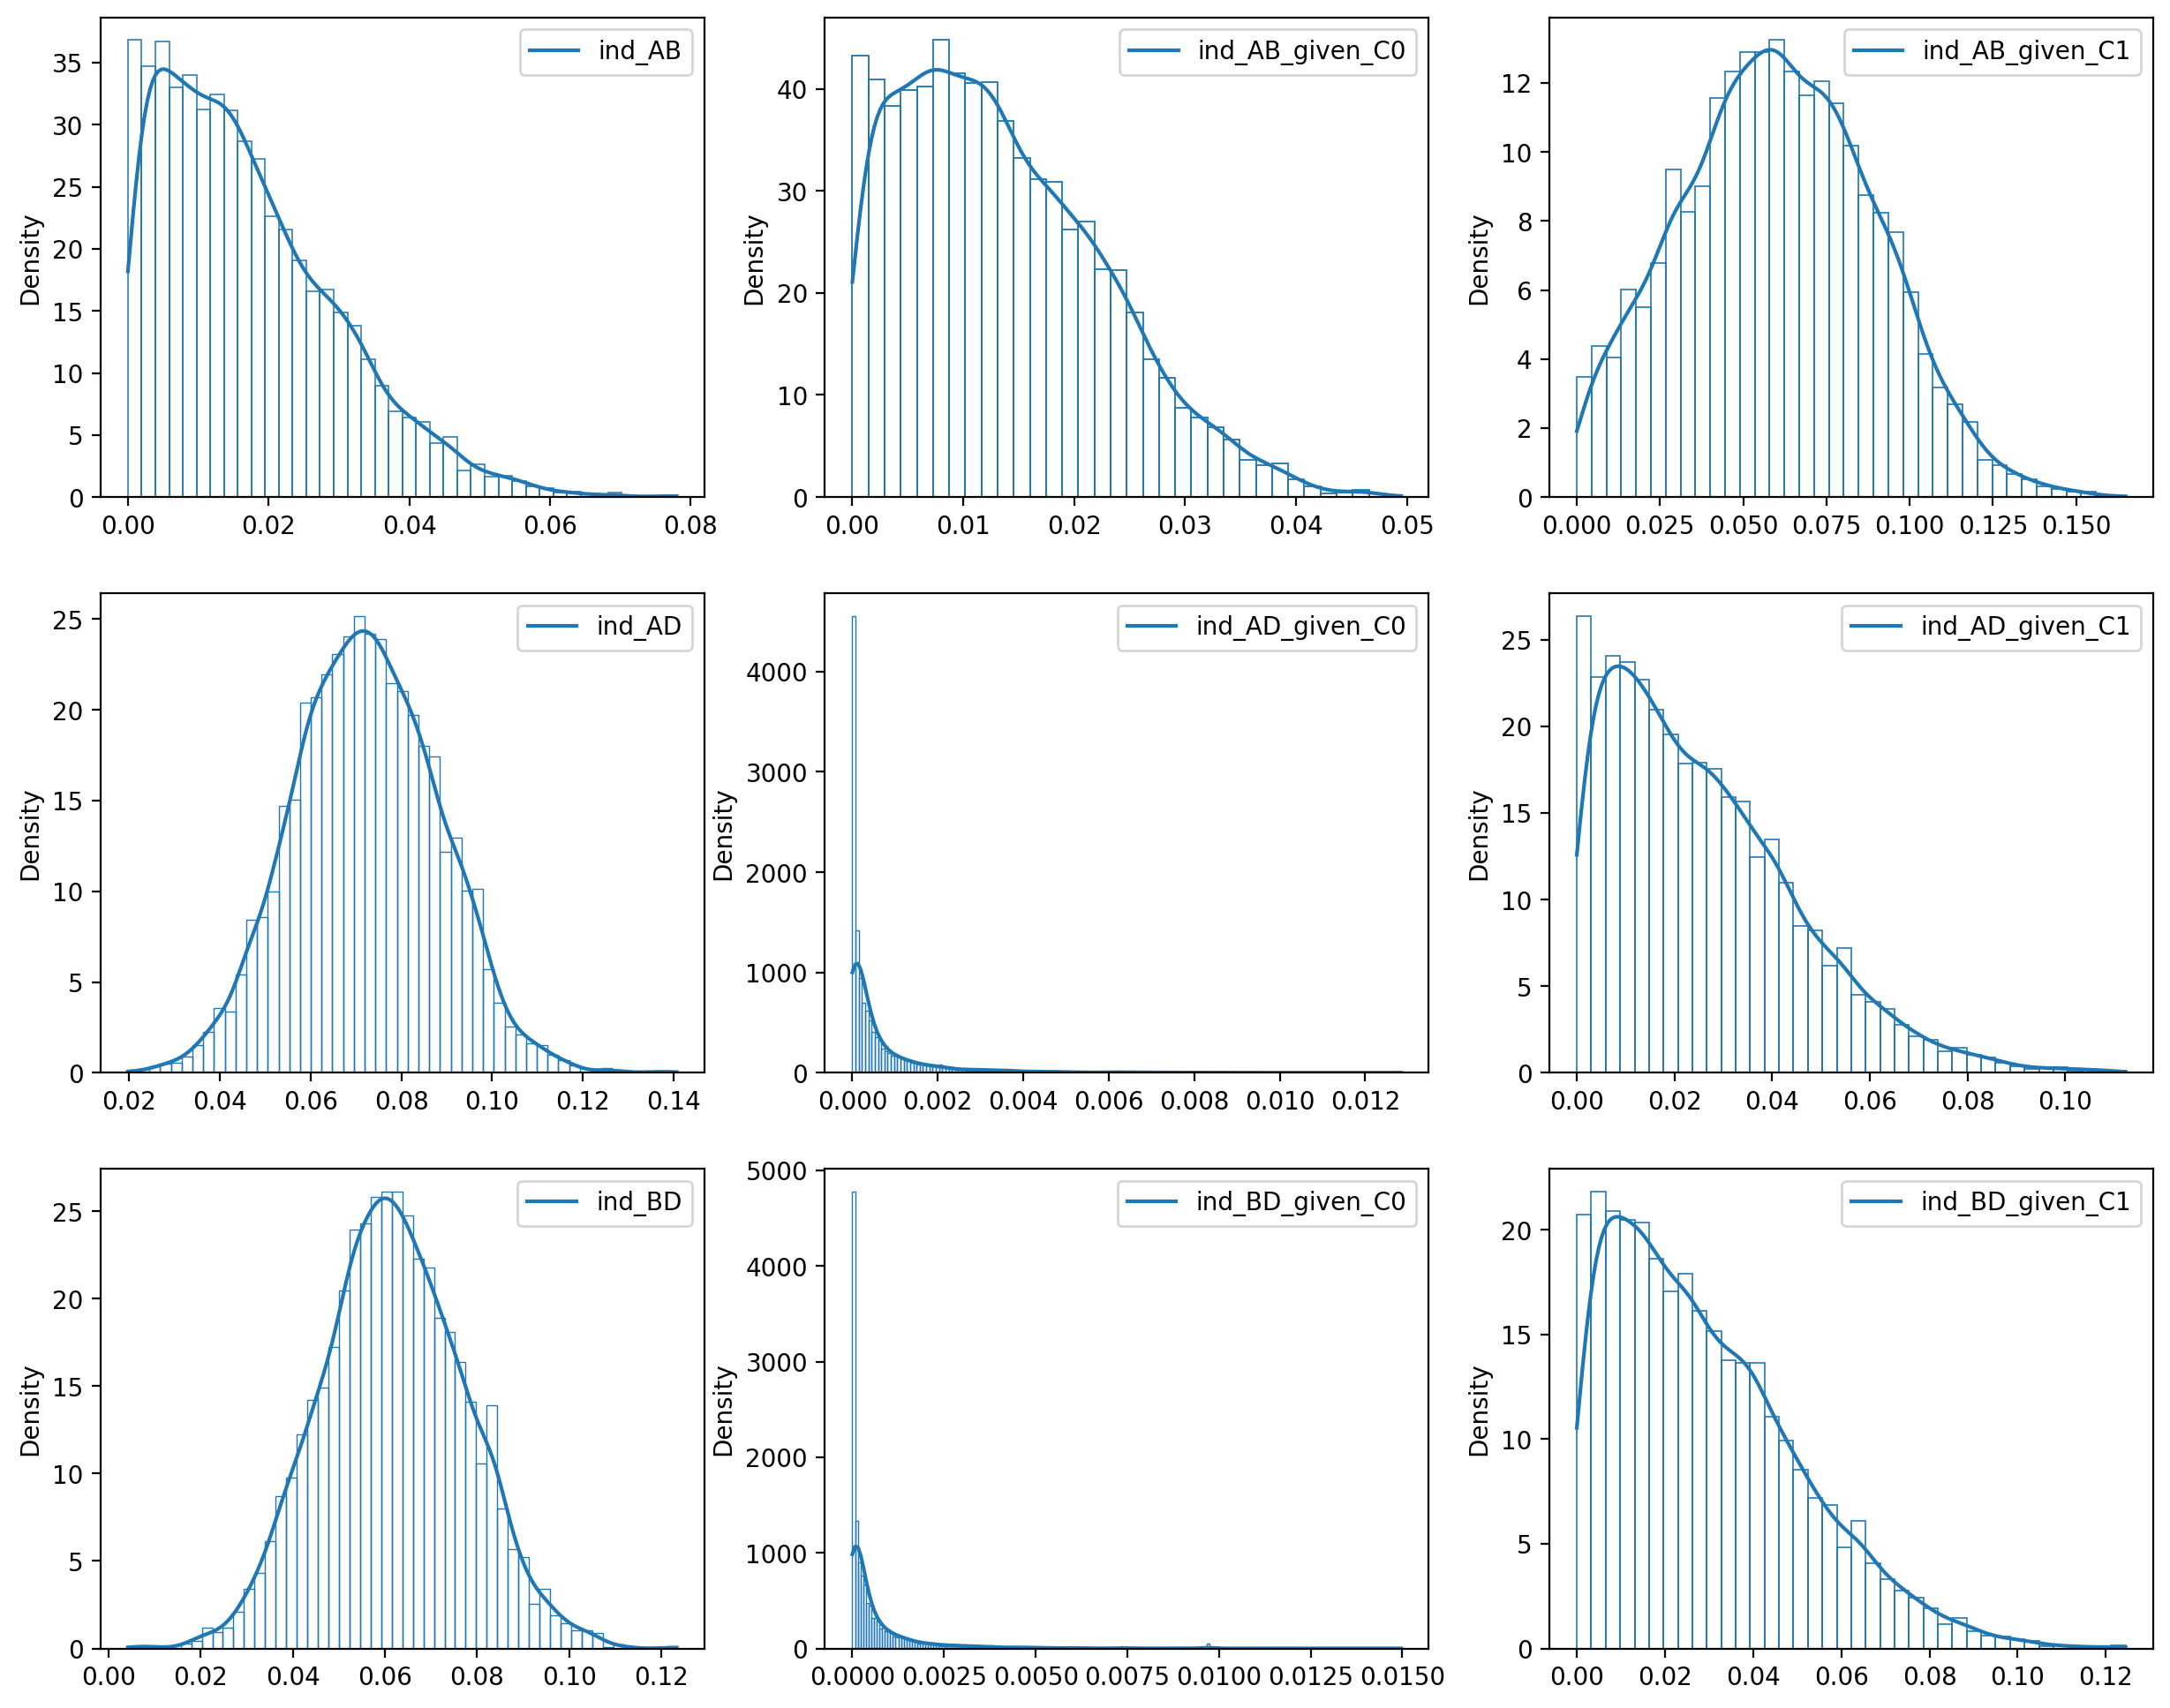

In [29]:
# STEP 2 : Check independence between conditional distributions. 

fix, ax = plt.subplots(3,3, figsize = (15,12))

ind_AB_given_C0 = abs(samples_p_A_and_B_given_C0-samples_p_A_given_C0*samples_p_B_given_C0)
ind_AB_given_C1 = abs(samples_p_A_and_B_given_C1-samples_p_A_given_C1*samples_p_B_given_C1)
ind_AD_given_C0 = abs(samples_p_A_and_D_given_C0-samples_p_A_given_C0*samples_p_D_given_C0)
ind_AD_given_C1 = abs(samples_p_A_and_D_given_C1-samples_p_A_given_C1*samples_p_D_given_C1)
ind_BD_given_C0 = abs(samples_p_B_and_D_given_C0-samples_p_B_given_C0*samples_p_D_given_C0)
ind_BD_given_C1 = abs(samples_p_B_and_D_given_C1-samples_p_B_given_C1*samples_p_D_given_C1)

sns.histplot(ind_AB, kde=True, ax=ax[0,0], fill= False, stat = "density");
sns.histplot(ind_AB_given_C0, kde=True, ax=ax[0,1], fill= False, stat = "density");
sns.histplot(ind_AB_given_C1, kde=True, ax=ax[0,2], fill= False, stat = "density");

sns.histplot(ind_AD, kde=True, ax=ax[1,0], fill= False, stat = "density");
sns.histplot(ind_AD_given_C0, kde=True, ax=ax[1,1], fill= False, stat = "density");
sns.histplot(ind_AD_given_C1, kde=True, ax=ax[1,2], fill= False, stat = "density");

sns.histplot(ind_BD, kde=True, ax=ax[2,0], fill= False, stat = "density");
sns.histplot(ind_BD_given_C0, kde=True, ax=ax[2,1], fill= False, stat = "density");
sns.histplot(ind_BD_given_C1, kde=True, ax=ax[2,2], fill= False, stat = "density");

ax[0,0].legend(["ind_AB"])
ax[0,1].legend(["ind_AB_given_C0"])
ax[0,2].legend(["ind_AB_given_C1"])
ax[1,0].legend(["ind_AD"])
ax[1,1].legend(["ind_AD_given_C0"])
ax[1,2].legend(["ind_AD_given_C1"])
ax[2,0].legend(["ind_BD"])
ax[2,1].legend(["ind_BD_given_C0"])
ax[2,2].legend(["ind_BD_given_C1"])

# for m in [0,1,2]:
#     for n in [0,1,2]:
#         ax[m,n].set_xlim((-0.2,+0.2))

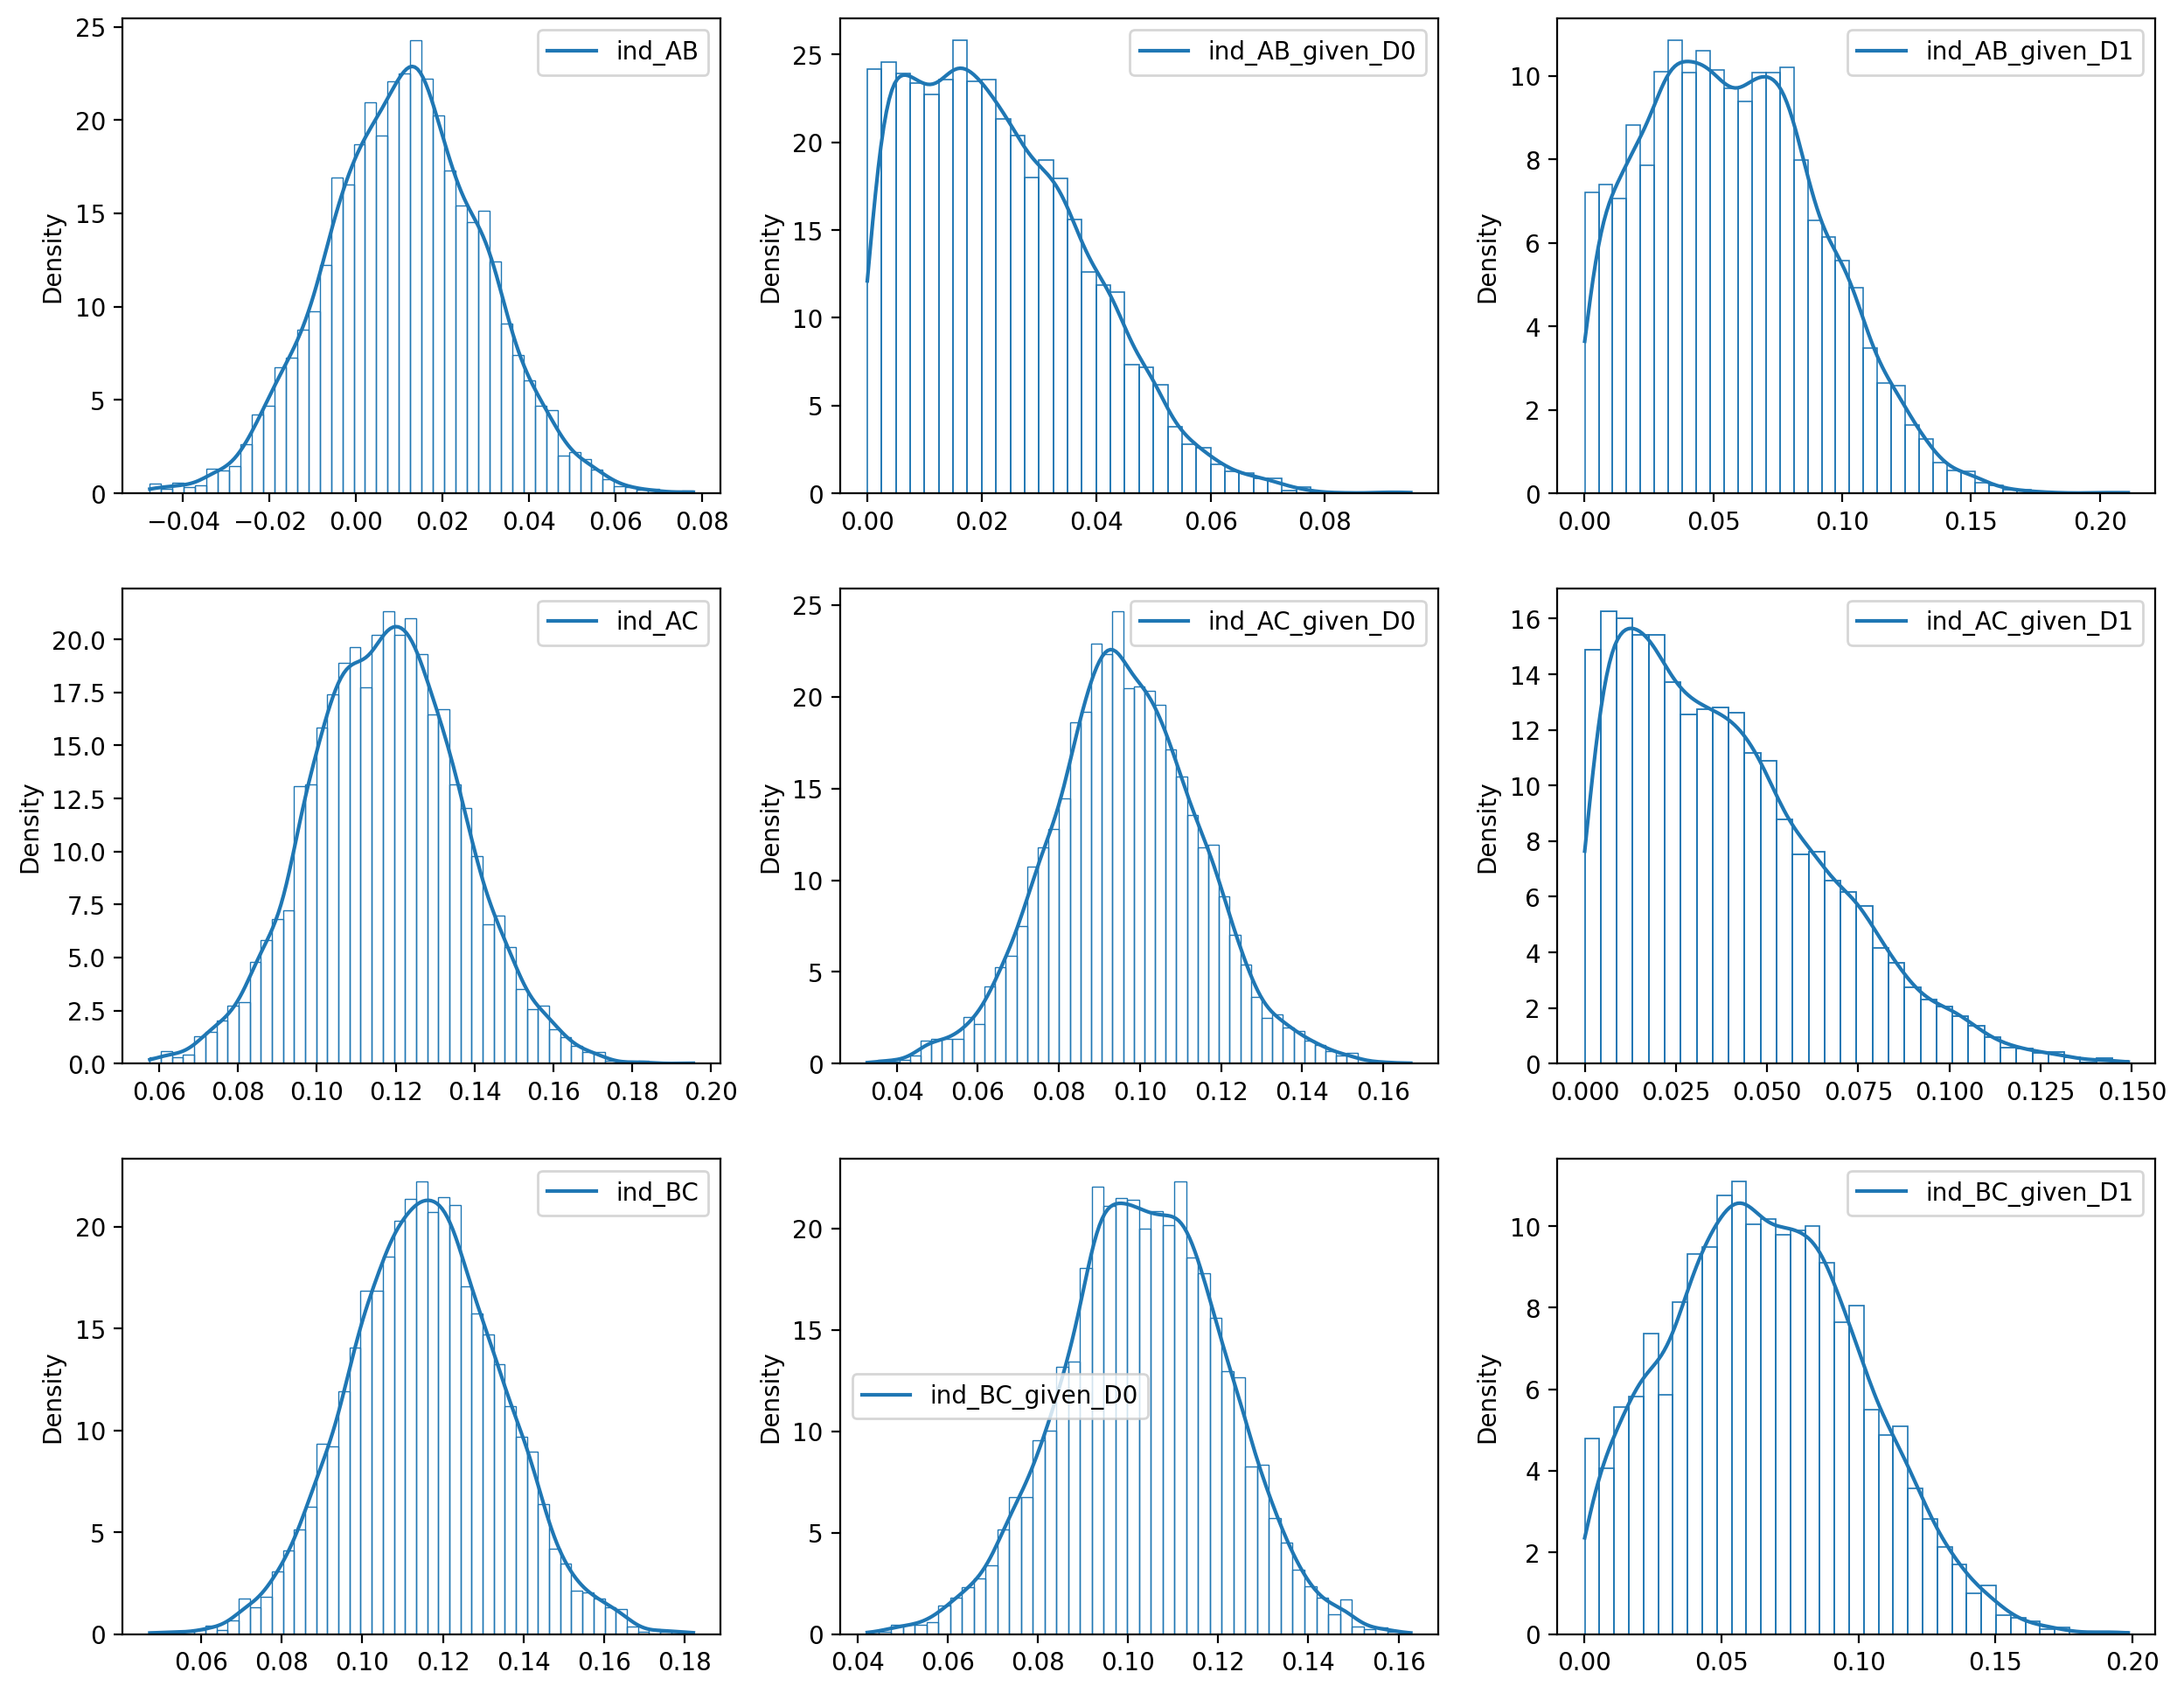

In [27]:
# STEP 2 : Check independence between conditional distributions. 

fix, ax = plt.subplots(3,3, figsize = (15,12))

ind_AB_given_D0 = abs(samples_p_A_and_B_given_D0-samples_p_A_given_D0*samples_p_B_given_D0)
ind_AB_given_D1 = abs(samples_p_A_and_B_given_D1-samples_p_A_given_D1*samples_p_B_given_D1)
ind_AC_given_D0 = abs(samples_p_A_and_C_given_D0-samples_p_A_given_D0*samples_p_C_given_D0)
ind_AC_given_D1 = abs(samples_p_A_and_C_given_D1-samples_p_A_given_D1*samples_p_C_given_D1)
ind_BC_given_D0 = abs(samples_p_B_and_C_given_D0-samples_p_B_given_D0*samples_p_C_given_D0)
ind_BC_given_D1 = abs(samples_p_B_and_C_given_D1-samples_p_B_given_D1*samples_p_C_given_D1)

sns.histplot(ind_AB, kde=True, ax=ax[0,0], fill= False, stat = "density");
sns.histplot(ind_AB_given_D0, kde=True, ax=ax[0,1], fill= False, stat = "density");
sns.histplot(ind_AB_given_D1, kde=True, ax=ax[0,2], fill= False, stat = "density");

sns.histplot(ind_AC, kde=True, ax=ax[1,0], fill= False, stat = "density");
sns.histplot(ind_AC_given_D0, kde=True, ax=ax[1,1], fill= False, stat = "density");
sns.histplot(ind_AC_given_D1, kde=True, ax=ax[1,2], fill= False, stat = "density");

sns.histplot(ind_BC, kde=True, ax=ax[2,0], fill= False, stat = "density");
sns.histplot(ind_BC_given_D0, kde=True, ax=ax[2,1], fill= False, stat = "density");
sns.histplot(ind_BC_given_D1, kde=True, ax=ax[2,2], fill= False, stat = "density");

ax[0,0].legend(["ind_AB"])
ax[0,1].legend(["ind_AB_given_D0"])
ax[0,2].legend(["ind_AB_given_D1"])
ax[1,0].legend(["ind_AC"])
ax[1,1].legend(["ind_AC_given_D0"])
ax[1,2].legend(["ind_AC_given_D1"])
ax[2,0].legend(["ind_BC"])
ax[2,1].legend(["ind_BC_given_D0"])
ax[2,2].legend(["ind_BC_given_D1"])

# for m in [0,1,2]:
#     for n in [0,1,2]:
#         ax[m,n].set_xlim((-0.2,+0.2))